In [3365]:
#Data Structures
import pandas as pd
import numpy as np

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, accuracy_score

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3366]:
df_train = pd.read_csv("train.csv")
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


### Data Understanding

In [3367]:
df_train.shape

(69999, 172)

In [3368]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [3369]:
df_train.dtypes

id                     int64
circle_id              int64
loc_og_t2o_mou       float64
std_og_t2o_mou       float64
loc_ic_t2o_mou       float64
                      ...   
aon                    int64
aug_vbc_3g           float64
jul_vbc_3g           float64
jun_vbc_3g           float64
churn_probability      int64
Length: 172, dtype: object

## Data Preprocessing

### Check Missing Values

In [3370]:
df_train.isna().sum()

id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

In [3371]:
# Get columns which have missing values
missing_cols = df_train.columns[df_train.isnull().any()]
print(missing_cols)

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       ...
       'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8'],
      dtype='object', length=125)


In [3372]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df_train.isnull().sum()/len(df_train.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
arpu_3g_6,74.9
count_rech_2g_6,74.9
night_pck_user_6,74.9
arpu_2g_6,74.9
date_of_last_rech_data_6,74.9
...,...
last_day_rch_amt_8,0.0
vol_2g_mb_6,0.0
vol_2g_mb_7,0.0
vol_2g_mb_8,0.0


Observations : For most of the columns more then 74% values are missing.

In [3373]:
def get_null_counts_map(df, cols):
    null_counts_map = {}
    for col in cols:
        null_counts_map[col] = df[col].isnull().sum()
    return null_counts_map

In [3374]:
def filter_columns_by_regex(df, regstr):
    filtered_columns = df.columns[df.columns.str.contains(regstr,regex=True)]
    print(filtered_columns.tolist())
    return filtered_columns

In [3375]:
def show_na_percentage(df):
    print(100*df.isnull().mean().sort_values(ascending=False))

In [3376]:
def get_percentage_na_columns_by_threshold(df, threshold):
    # making list of columns that have high missing values that we want to remove
    rmcols=[]
    for i in df.columns:
        if(df[i].isnull().mean()*100>=threshold):
            rmcols.append(i)
    return rmcols

In [3377]:
#Replacing the NAN values with 0, considering there were no recharges done by the customer.
def impute_null_columns(df, cols):
    if cols is None:
        df=df.replace(np.nan,0)
    else:
        for col in cols:
            df[col] = df[col].replace(np.NaN,0.0)
    return df

In [3378]:
#let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
def add_total_rech_amt_data(df):
    rc_col_map = {
        "6": ["av_rech_amt_data_6","total_rech_data_6"],
        "7": ["av_rech_amt_data_7","total_rech_data_7"],
        "8": ["av_rech_amt_data_8","total_rech_data_8"]
    }
    for i, rc_cols in rc_col_map.items():
        df["total_rech_amt_data_" + i] = df[rc_cols[0]] + df[rc_cols[1]]
    return df

In [3379]:
def add_avg_rech_amt_good_phase(df, rc_cols):
    value = 0
    for rc in rc_cols:
        value += df[rc]
    df['total_avg_rech_amnt_6_7_GPhase'] = value/2
    return df


In [3380]:
def drop_cols(df,cols):
    df.drop(cols,axis=1,inplace=True)
    if not isinstance(cols, list):
        print(cols.to_list())

In [3381]:
recharge_columns = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
df_train = impute_null_columns(df_train,recharge_columns)

In [3382]:
df_train = add_total_rech_amt_data(df_train)

In [3383]:
#Defining total average recharge amount for good phase for months 6 and 7 (the good phase)
rc_cols = ["total_rech_amt_6", "total_rech_amt_7", "total_rech_amt_data_6", "total_rech_amt_data_7"]
df_train = add_avg_rech_amt_good_phase(df_train, rc_cols)

In [3384]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = df_train.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)
print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter),"\n")

telecom_df_high_val_cust = df_train[df_train.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('Dataframe Shape after Filtering High Value Customers: ' + str(telecom_df_high_val_cust.shape),"\n")

70 percentile of 6th and 7th months avg recharge amount: 432.5 

Dataframe Shape after Filtering High Value Customers: (20984, 176) 



#### Tag churners and remove attributes of the churn phase

<ol>
<li> Now tagging the churned customers (churn = 1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
<li> The attributes we need to use to tag churners are:
<ol>
<li>total_ic_mou_8
<li>total_og_mou_8
<li>vol_2g_mb_8
<li>vol_3g_mb_8
</ol>
<li>After tagging churners, we will remove all the attributes corresponding to the churn phase (all attributes having ‘ _8’, etc. in their names).
</ol>

In [3385]:
#taking all the mentioned columns in a dataframe
high_val_cust_8 = ['total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8','vol_3g_mb_8']

# Checking for missing values
df = 100*telecom_df_high_val_cust.loc[:,high_val_cust_8].isnull().sum()/len(telecom_df_high_val_cust)
df

total_ic_mou_8    0.0
total_og_mou_8    0.0
vol_2g_mb_8       0.0
vol_3g_mb_8       0.0
dtype: float64

In [3386]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/934049836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust['churn']= 0


In [3387]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_8 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_8 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_8 ==0) & \
             (telecom_df_high_val_cust.vol_3g_mb_8 ==0)

# set all which having is_churned True condition as 1
telecom_df_high_val_cust.loc[is_churned,'churn']=1

In [3388]:
# % of churned customers
churned_customers_percentage = round(100*telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust),2)
print("The Percentage of Churned Customers are",churned_customers_percentage,"%")

The Percentage of Churned Customers are 5.47 %


## Exploratory data analysis (EDA)

#### drop columns with only 1/2 unique values as those would not add any value to our model

In [3389]:
def get_drop_col_with_unique_col(df):
    drop_col_with_unique_col_map = {}
    for i in df.columns :
        uniq_vals = len(pd.unique(df[i]))
        if uniq_vals in [1, 2]:
            drop_col_with_unique_col_map[i] = uniq_vals
    print(drop_col_with_unique_col_map)
    return drop_col_with_unique_col_map

drop_col_with_unique_col_map = get_drop_col_with_unique_col(telecom_df_high_val_cust)
del drop_col_with_unique_col_map['churn']
del drop_col_with_unique_col_map['churn_probability']

{'circle_id': 1, 'loc_og_t2o_mou': 2, 'std_og_t2o_mou': 2, 'loc_ic_t2o_mou': 2, 'last_date_of_month_6': 1, 'last_date_of_month_7': 2, 'last_date_of_month_8': 2, 'std_og_t2c_mou_6': 2, 'std_og_t2c_mou_7': 2, 'std_og_t2c_mou_8': 2, 'std_ic_t2o_mou_6': 2, 'std_ic_t2o_mou_7': 2, 'std_ic_t2o_mou_8': 2, 'churn_probability': 2, 'churn': 2}


In [3390]:
print("Features before dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))
telecom_df_high_val_cust.drop(drop_col_with_unique_col_map.keys(),axis=1,inplace=True)
print("Features after dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))

Features before dropping unique values : 177
Features after dropping unique values : 164


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/2023862527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust.drop(drop_col_with_unique_col_map.keys(),axis=1,inplace=True)


#### Fix date type columns

In [3391]:
def get_date_cols(df):
    date_cols = []
    for i in df.columns :
        if df[i].dtypes == 'object':
            print(i," - ",df[i].dtypes)
            date_cols.append(i)
    return date_cols

def convert_to_datetime(df, date_cols):
    #convert them to Date Type
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    return df

In [3392]:
date_cols = get_date_cols(telecom_df_high_val_cust)

telecom_df_high_val_cust = convert_to_datetime(telecom_df_high_val_cust, date_cols)

date_of_last_rech_6  -  object
date_of_last_rech_7  -  object
date_of_last_rech_8  -  object
date_of_last_rech_data_6  -  object
date_of_last_rech_data_7  -  object
date_of_last_rech_data_8  -  object


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col])
/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col])
/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/2237078713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [3393]:
# create box plot function for  6th, 7th and 8th month variables
def plot_box_chart(df, attribute, target):
    plt.figure(figsize=(20,16))
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x=target,hue=target,showfliers=False,palette=("plasma"))
    plt.show()

In [3394]:
#Plotting Bar Chart
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

In [3395]:
def plot_heatmap(df, filter):
    #Checking the corelation
    plt.subplots(figsize = (20,10))
    #Plotting heatmap of numerical features
    sns.heatmap(round(df.filter(filter).corr(),2), cmap='coolwarm' , annot=True, center = 0)
    plt.show()

In [3396]:
def plot_distplot(df, col, xlabel, ylabel, title):
    plt.figure(figsize=(14,8))
    ax = sns.distplot(df[col], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

In [3397]:
def plot_countplot(df, attribute, target):
    plt.figure(figsize=(14,8))
    sns.countplot(x = attribute, hue = target,data = df,palette=("plasma"))
    plt.show()

In [3398]:
def plot_pie_chart(df, target, ylabel, title):
    pie_chart = df[target].value_counts()*100.0 /len(df)
    ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
    ax.set_ylabel(ylabel,fontsize = 12)
    ax.set_title(title, fontsize = 12)
    plt.show()

In [3399]:
#Lets extract the columns containing recharge amount in their variable name
recharge_amnt_columns = filter_columns_by_regex(telecom_df_high_val_cust, 'rech_amt')

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_rech_amt_data_8']


#### Box Plot - total_rech_amt against churn

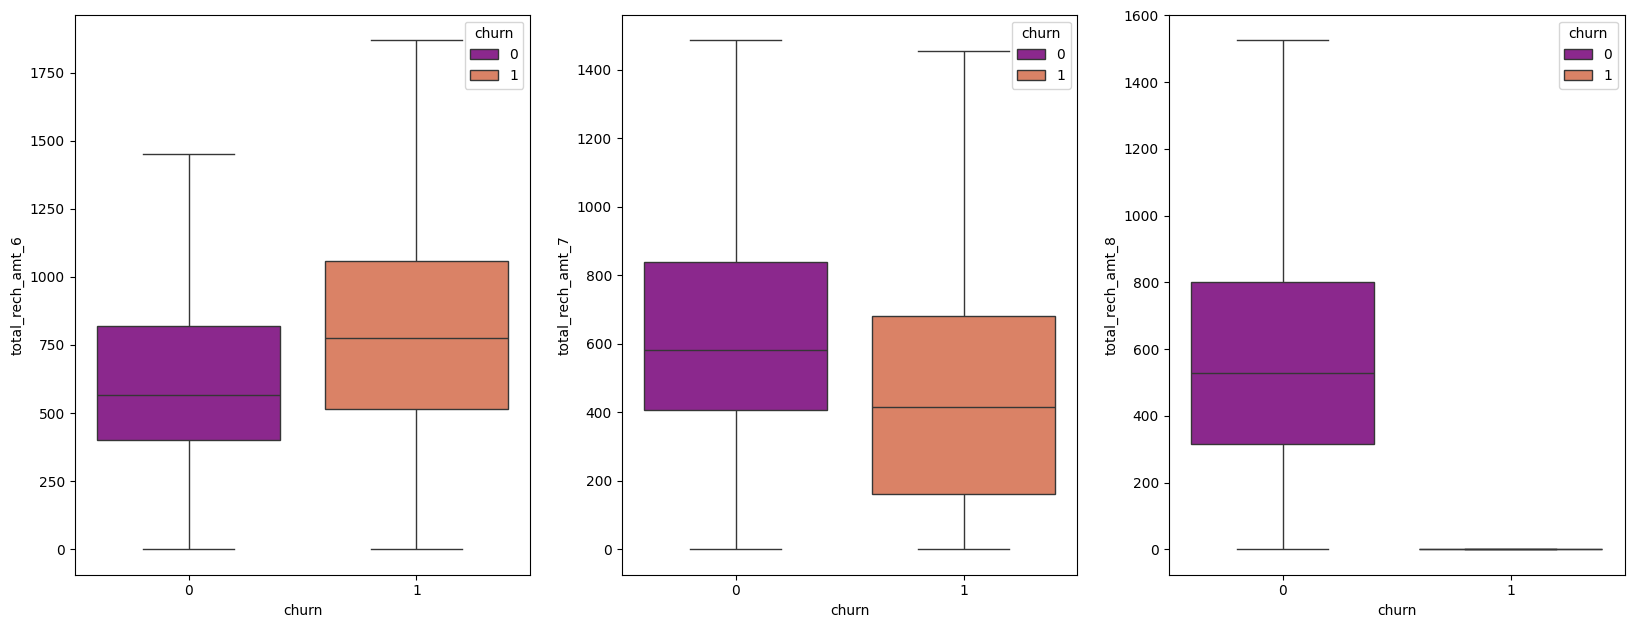

In [3400]:
# Ploting for total recharge amount:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_amt', 'churn')

Observations : We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

#### Box Plot - total_rech_amt_data against churn

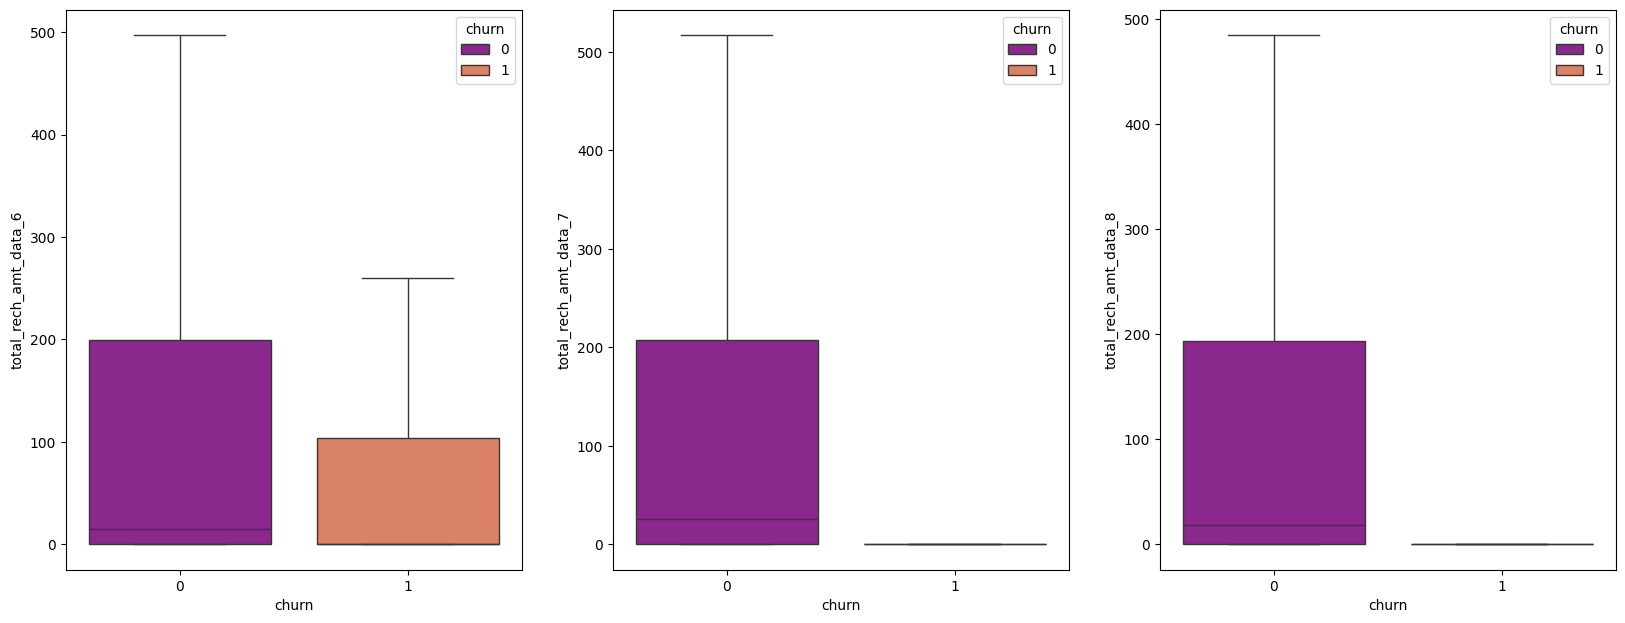

In [3401]:
# Ploting for total recharge amount for data:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_amt_data', 'churn')

#### Box Plot - max_rech_amt

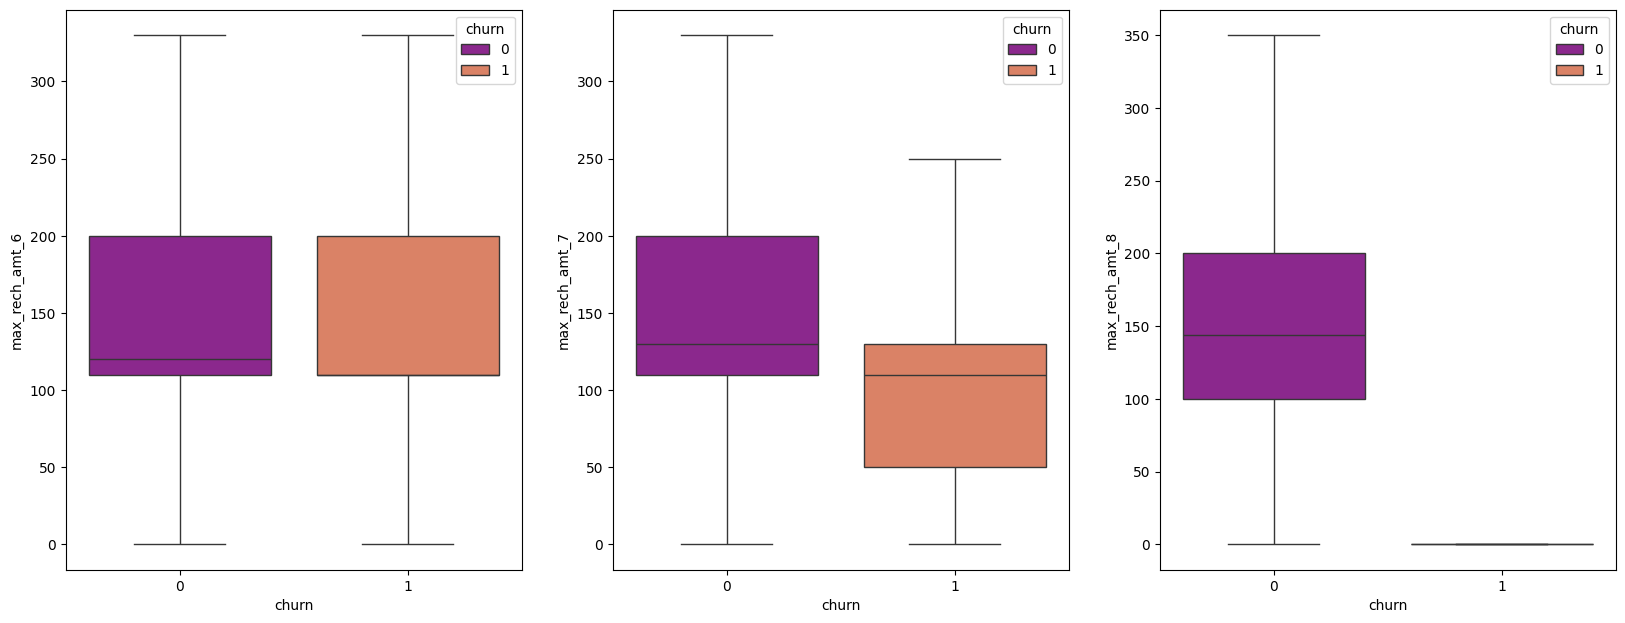

In [3402]:
# Ploting for maximum recharge amount for data:
plot_box_chart(telecom_df_high_val_cust, 'max_rech_amt', 'churn')

Observations : We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

#### Box Plot - total_rech_num

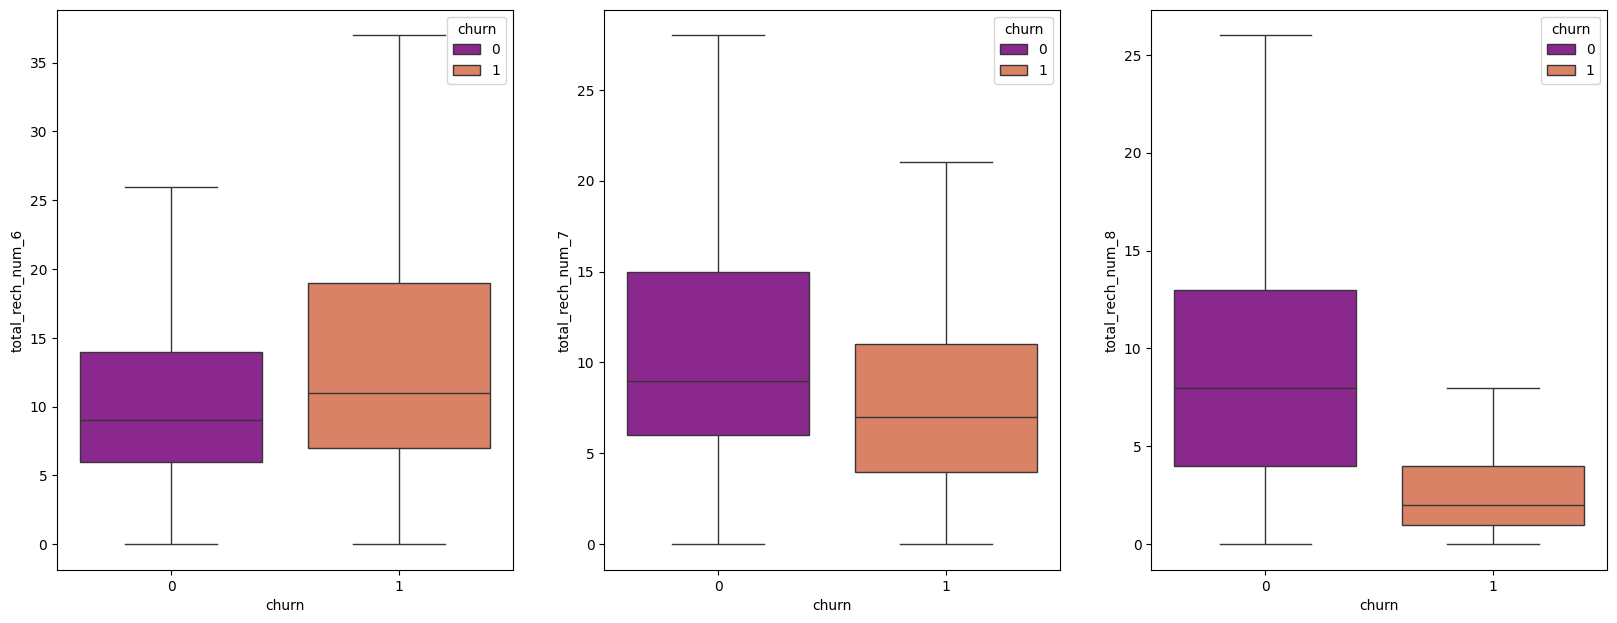

In [3403]:
#Ploting for Total recharge for Number:
plot_box_chart(telecom_df_high_val_cust, 'total_rech_num', 'churn')

Observations : We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

In [3404]:
# get null counts of maximum recharge data
max_rech_data_cols = ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']
max_rech_data_null_counts = get_null_counts_map(telecom_df_high_val_cust, max_rech_data_cols)
max_rech_data_null_counts

{'max_rech_data_6': 10585, 'max_rech_data_7': 10372, 'max_rech_data_8': 10854}

In [3405]:
telecom_df_high_val_cust = impute_null_columns(telecom_df_high_val_cust, max_rech_data_cols)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


### Box Plot - max_rech_data

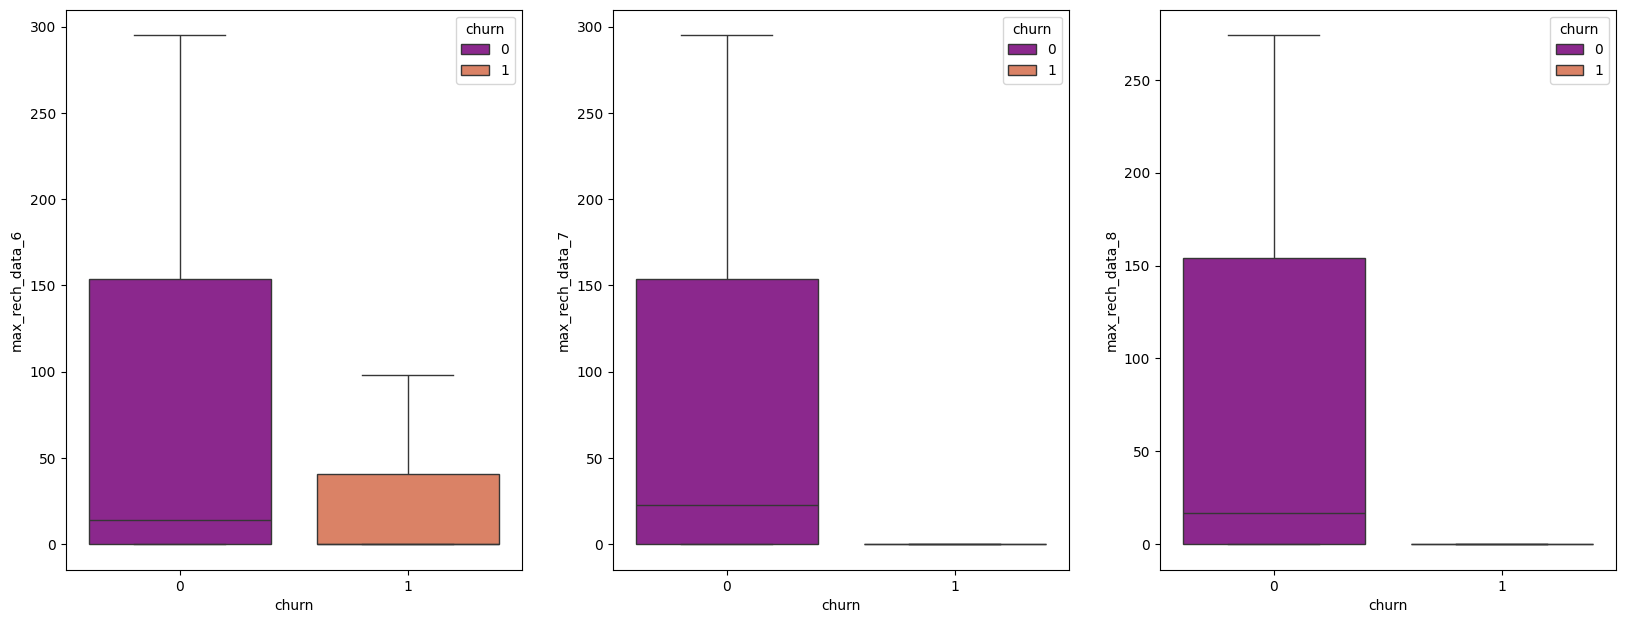

In [3406]:
# Ploting for maximum recharge for data:
plot_box_chart(telecom_df_high_val_cust, 'max_rech_data','churn')

Observations : We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

In [3407]:
#Extracting the last day recharge amount columns
last_day_rech_amt = filter_columns_by_regex(telecom_df_high_val_cust, 'day')

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']


### Box Plot - last_day_rch_amt

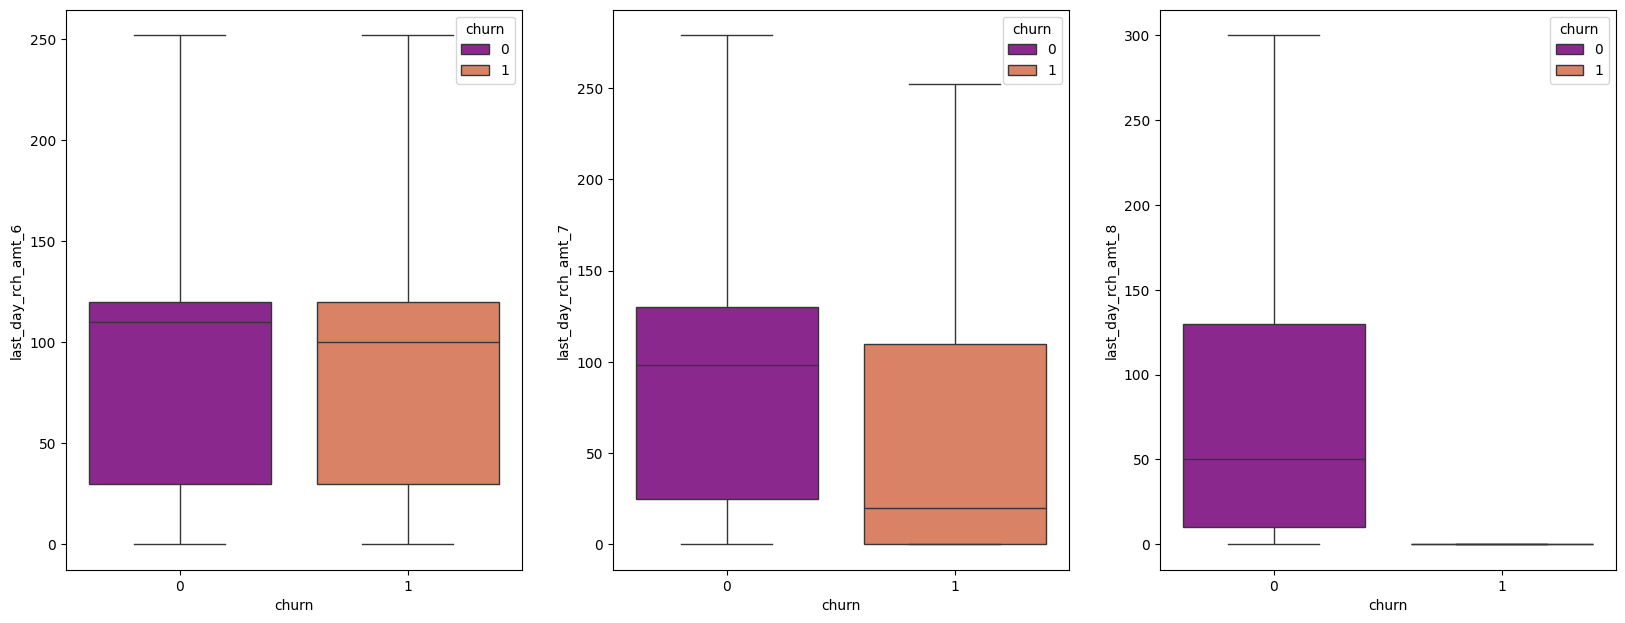

In [3408]:
# Ploting for last day recharge amount:
plot_box_chart(telecom_df_high_val_cust,'last_day_rch_amt','churn')

Observations : We are getting a huge drop in 8th month recharge amount for churned customers.

### 2G and 3G usage related Features

In [3409]:
usage_2g_and_3g = filter_columns_by_regex(telecom_df_high_val_cust, '2g|3g')

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [3410]:
# Calculate the percentage of null values for 2g and 3g columns
usage_2g_and_3g_null_counts_map = get_null_counts_map(telecom_df_high_val_cust, usage_2g_and_3g.to_list())
usage_2g_and_3g_null_counts_map

{'count_rech_2g_6': 10585,
 'count_rech_2g_7': 10372,
 'count_rech_2g_8': 10854,
 'count_rech_3g_6': 10585,
 'count_rech_3g_7': 10372,
 'count_rech_3g_8': 10854,
 'vol_2g_mb_6': 0,
 'vol_2g_mb_7': 0,
 'vol_2g_mb_8': 0,
 'vol_3g_mb_6': 0,
 'vol_3g_mb_7': 0,
 'vol_3g_mb_8': 0,
 'arpu_3g_6': 10585,
 'arpu_3g_7': 10372,
 'arpu_3g_8': 10854,
 'arpu_2g_6': 10585,
 'arpu_2g_7': 10372,
 'arpu_2g_8': 10854,
 'monthly_2g_6': 0,
 'monthly_2g_7': 0,
 'monthly_2g_8': 0,
 'sachet_2g_6': 0,
 'sachet_2g_7': 0,
 'sachet_2g_8': 0,
 'monthly_3g_6': 0,
 'monthly_3g_7': 0,
 'monthly_3g_8': 0,
 'sachet_3g_6': 0,
 'sachet_3g_7': 0,
 'sachet_3g_8': 0,
 'aug_vbc_3g': 0,
 'jul_vbc_3g': 0,
 'jun_vbc_3g': 0}

In [3411]:
usage_2g_and_3g_null_counts = []
for key, value in usage_2g_and_3g_null_counts_map.items():
    if value > 1:
        usage_2g_and_3g_null_counts.append(key)
usage_2g_and_3g_null_counts

['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [3412]:
# drop null values columns
drop_cols(telecom_df_high_val_cust, usage_2g_and_3g_null_counts)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1817087159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [3413]:
telecom_df_high_val_cust.shape

(20984, 152)

### Box Plot - vol_2g_mb

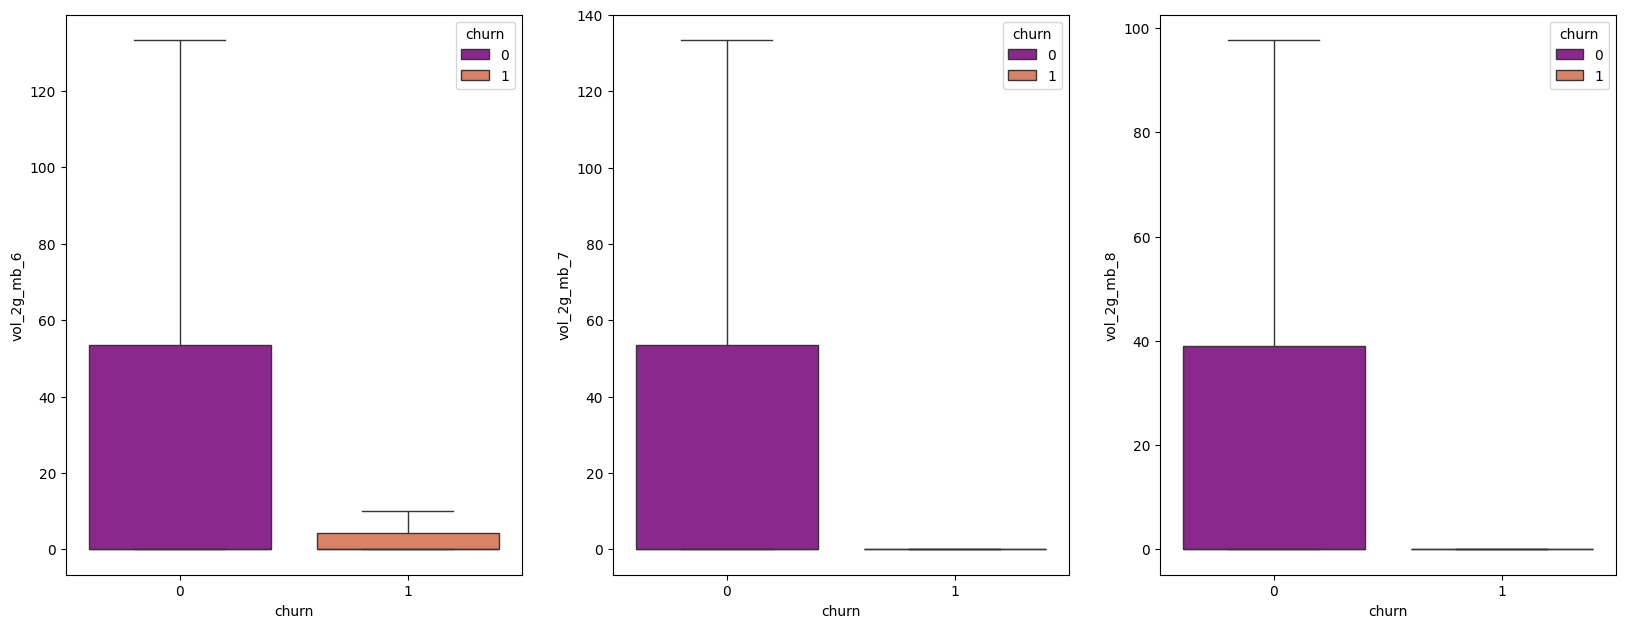

In [3414]:
# Ploting for volume of 2G and 3G usage columns:
plot_box_chart(telecom_df_high_val_cust, 'vol_2g_mb', 'churn')

### Box Plot - vol_3g_mb

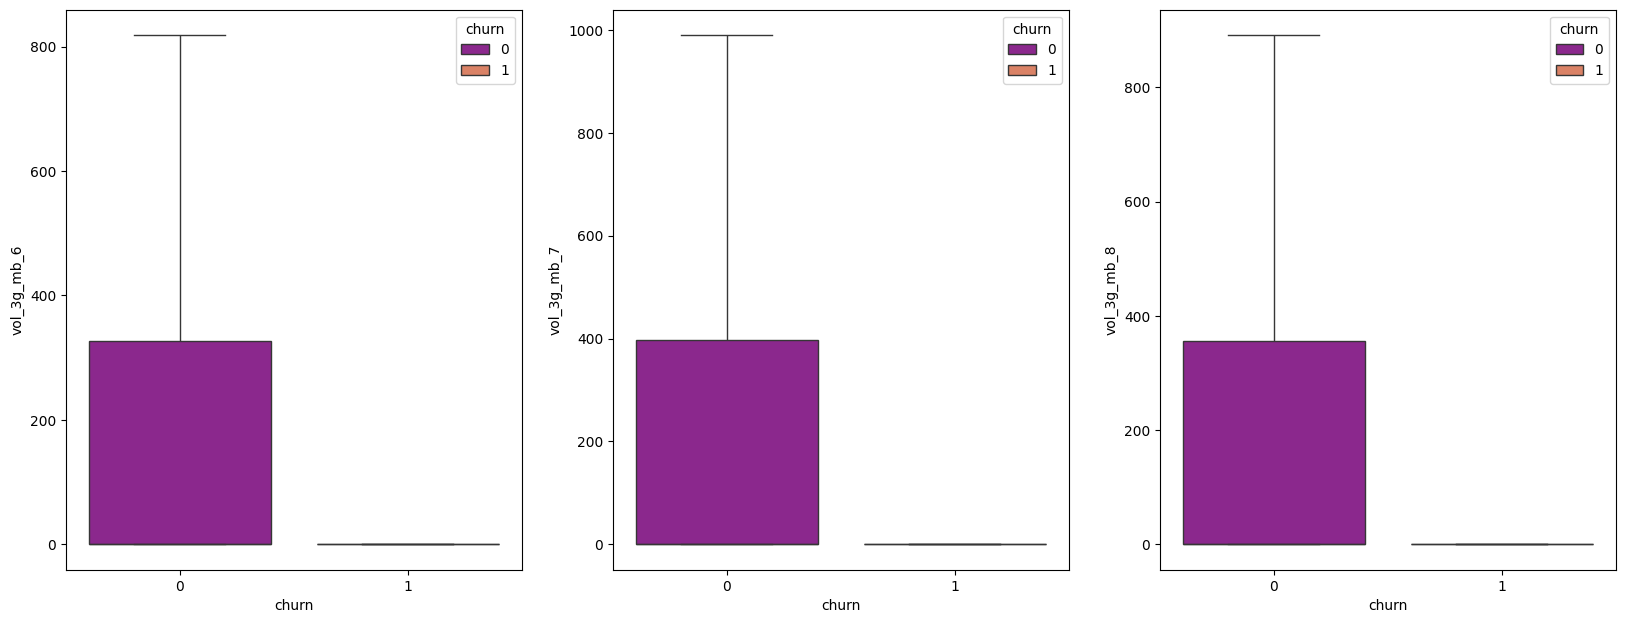

In [3415]:
plot_box_chart(telecom_df_high_val_cust, 'vol_3g_mb', 'churn')

Observations : We have two observations from above:
<ol>
<li> 2G and 3G usage for churned customers drops in 8th month
<li> We also see that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available.
</ol>

### Box Plot - monthly_2g

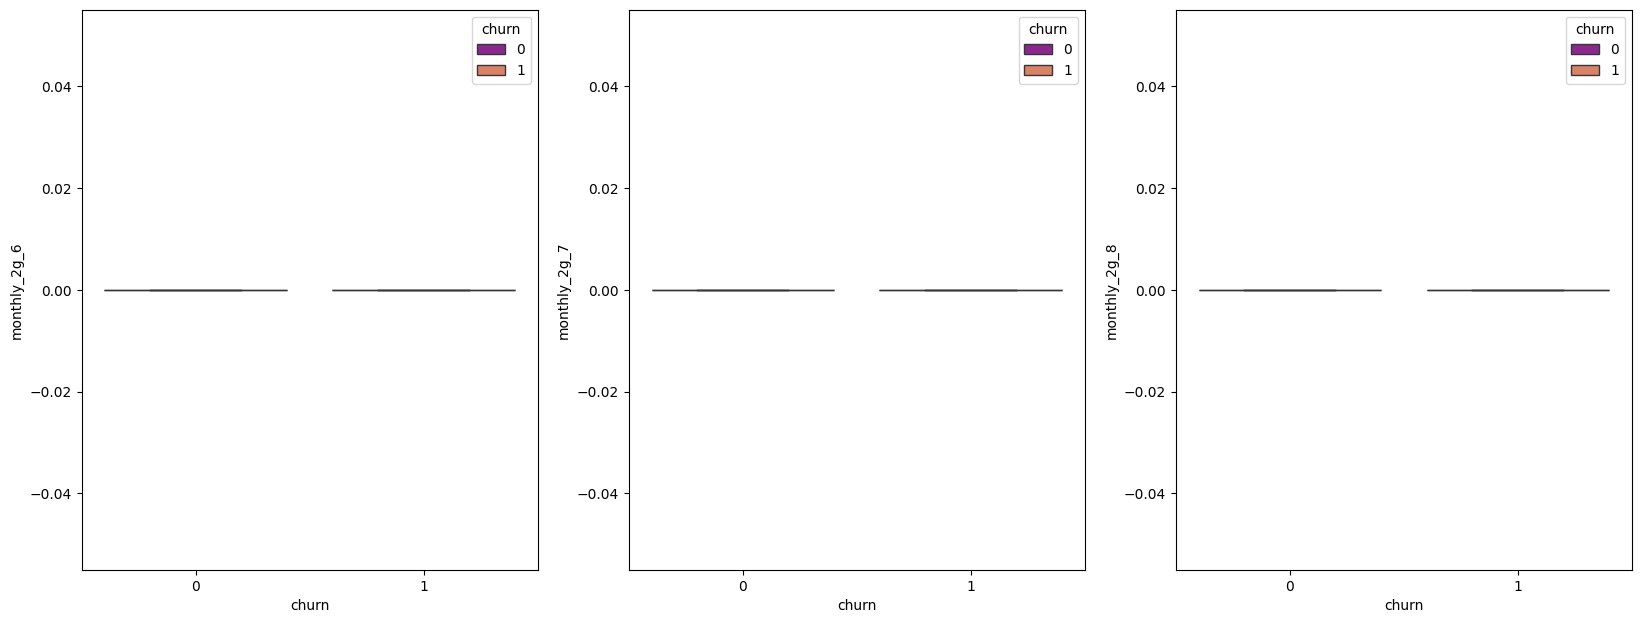

In [3416]:
# Ploting for monthly subscription :
plot_box_chart(telecom_df_high_val_cust, 'monthly_2g', 'churn')

Observations : Value range is very low, hence graph is not giving us proper justification result .Hence doing analysis by checking mean value.


In [3417]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = filter_columns_by_regex(telecom_df_high_val_cust, 'monthly_2g|monthly_3g')

['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']


In [3418]:
#Plotting monthly 2g and 3g
# plot_mean_bar_chart(telecom_df_high_val_cust, monthly_subcription_2g_3g)

Observations : Again we can see a drop in monthly subscription for churned customers in 8th Month.


### Volume based cost usage related Features

In [3419]:
vbc_column = filter_columns_by_regex(telecom_df_high_val_cust, 'vbc_')

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [3420]:
# Renaming month named vbc columns to 6,7,8 format
telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/3052465245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)


In [3421]:
vbc_column = filter_columns_by_regex(telecom_df_high_val_cust, 'vbc_3g')

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']


### Box Plot - vbc_3g

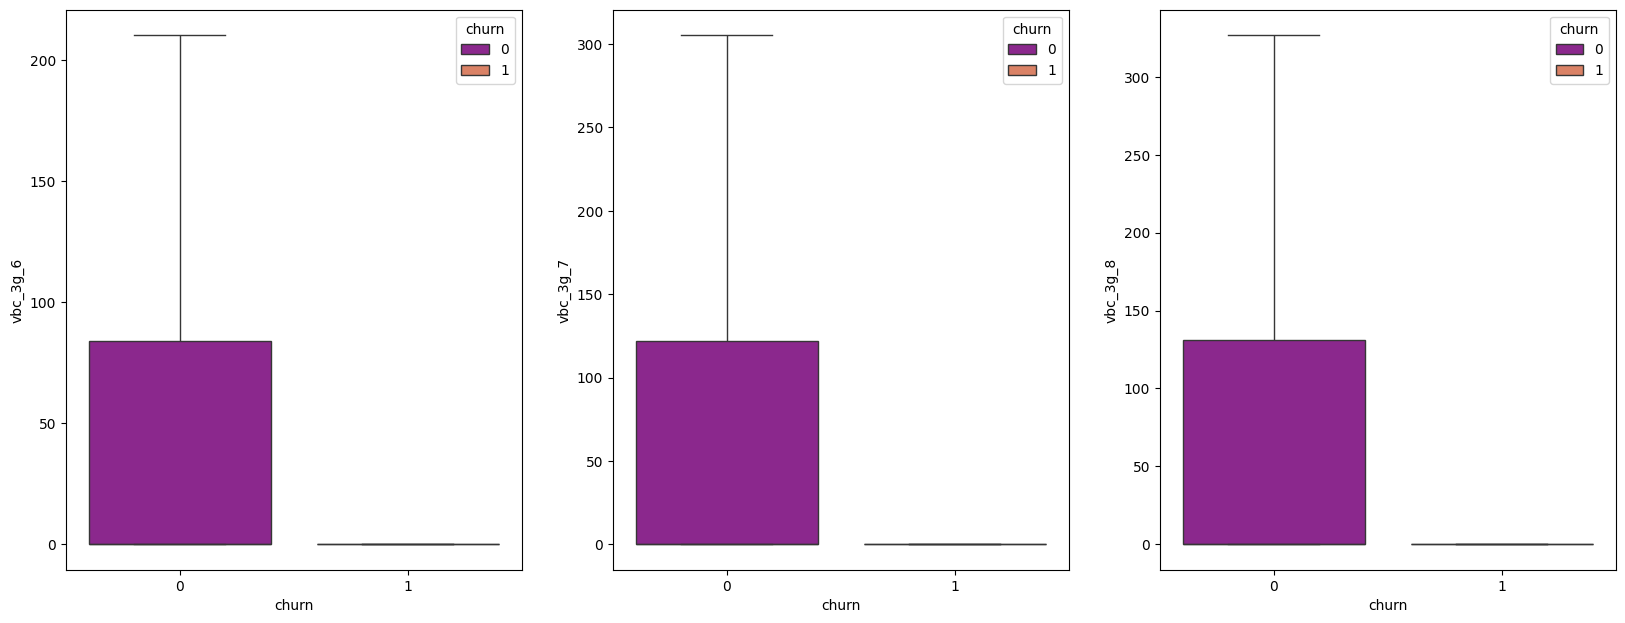

In [3422]:
# Ploting for volume based cost :
plot_box_chart(telecom_df_high_val_cust, 'vbc_3g', 'churn')

In [3423]:
# plot_mean_bar_chart(telecom_df_high_val_cust, vbc_column)

Observations : Significantly it showing that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [3424]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = filter_columns_by_regex(telecom_df_high_val_cust, 'sachet_2g|sachet_3g')

['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [3425]:
# plot_mean_bar_chart(telecom_df_high_val_cust, SC_2g_or_3g_col)

Observations : We can see the drop in sachet services in 8th month for churned cutsomers

### Average Revenue Per User related Features

In [3426]:
# Checking columns for average revenue per user
arpu_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'arpu_')

['arpu_6', 'arpu_7', 'arpu_8']


### Box Plot - vbc_3g

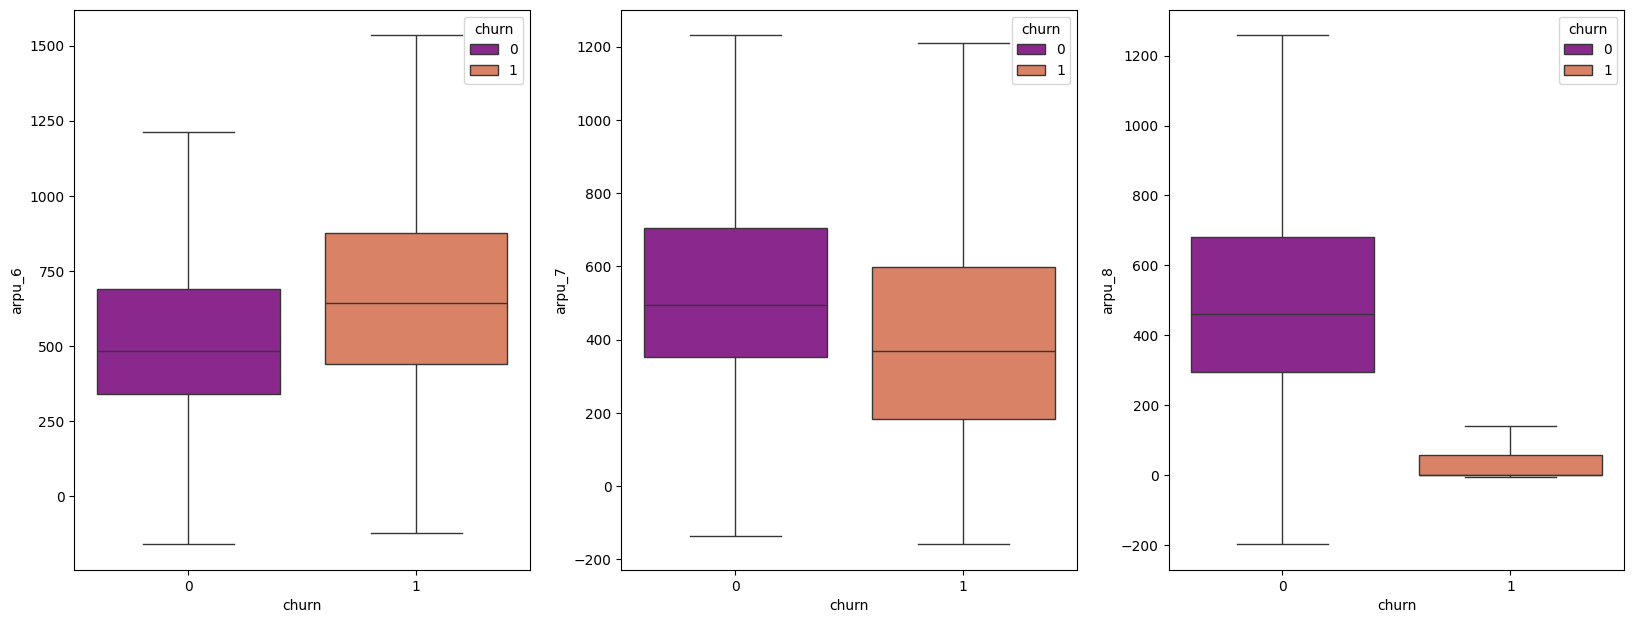

In [3427]:
# Plotting arpu
plot_box_chart(telecom_df_high_val_cust, 'arpu', 'churn')

In [3428]:
# plot_mean_bar_chart(telecom_df_high_val_cust, arpu_cols)

Observations : We can see that huge drops for Arpu in 8th month for churned customers

###  Minutes of usage - voice calls related Features

In [3429]:
mou_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6'

Observations : So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero


In [3430]:
telecom_df_high_val_cust = impute_null_columns(telecom_df_high_val_cust, mou_cols.to_list())

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


In [3431]:
mou_og_cols6 = filter_columns_by_regex(telecom_df_high_val_cust, '.*_og_.*mou_6')

['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6']


In [3432]:
telecom_df_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000
mean,28.558768,88.412276,170.866712,6.647443,1.549121,265.934996,177.757522,192.617813,1.894971,372.274326,2.383451,5.842503,647.098117
std,121.136006,233.410894,249.214341,20.571314,6.563695,380.845586,411.211260,412.078561,12.622126,612.028902,53.090602,19.016429,682.983177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.137500,24.380000,0.000000,0.000000,41.290000,0.000000,0.000000,0.000000,1.750000,0.000000,0.000000,176.330000
50%,0.000000,28.040000,86.960000,0.260000,0.000000,140.875000,6.020000,24.200000,0.000000,73.010000,0.000000,0.160000,464.255000
75%,0.000000,83.132500,221.032500,4.765000,0.000000,350.777500,140.250000,182.682500,0.000000,535.937500,0.000000,5.015000,885.795000
max,3775.110000,6431.330000,4696.830000,617.580000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


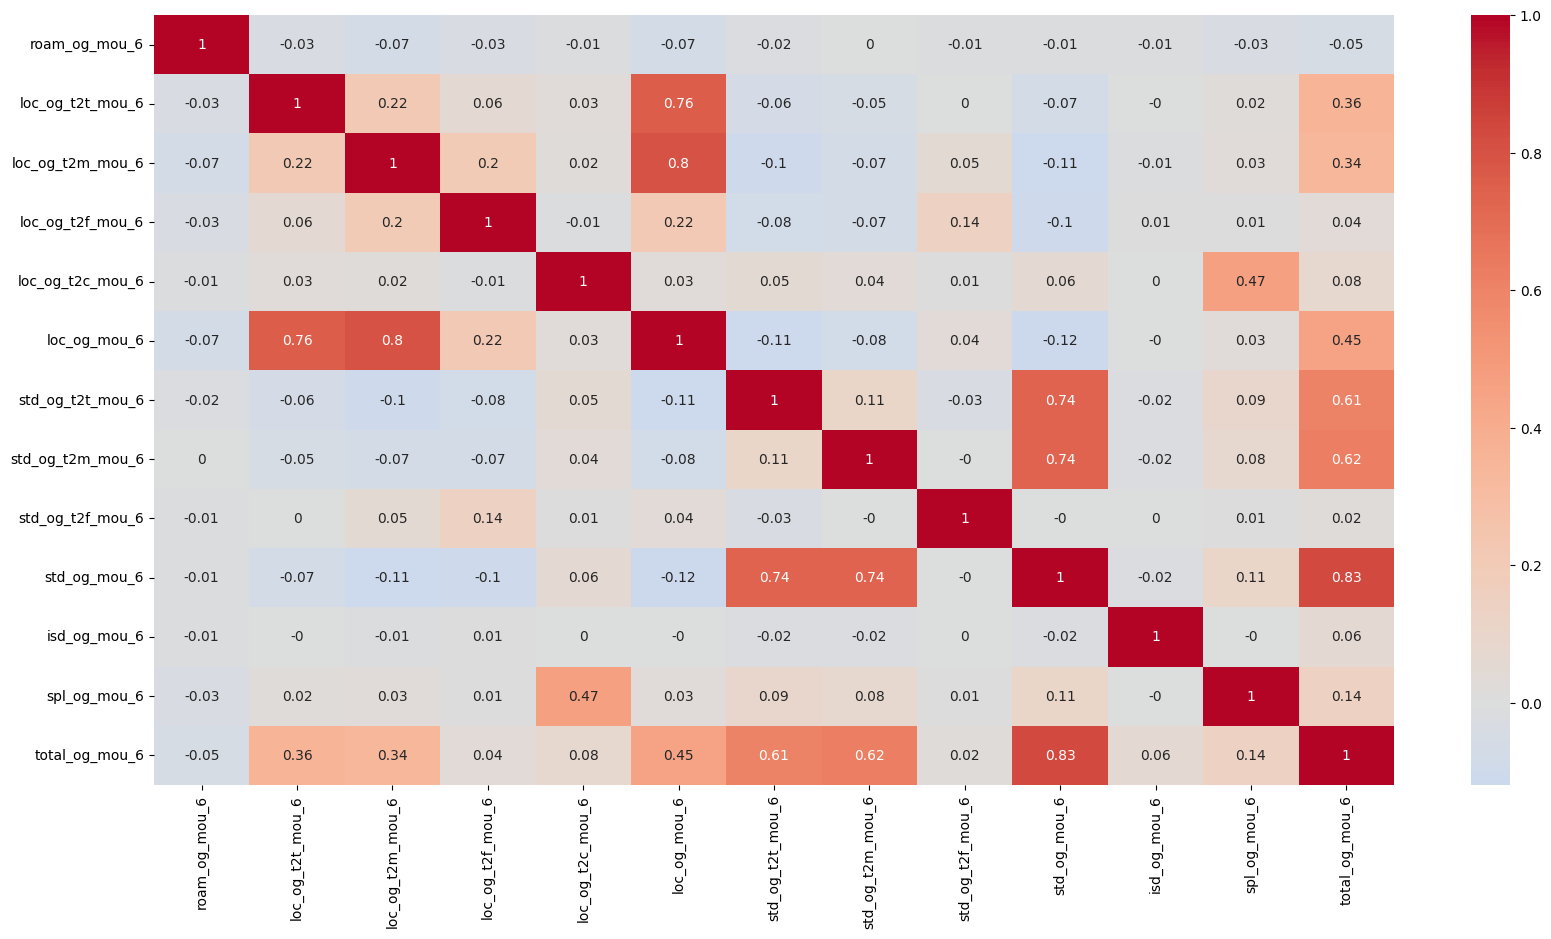

In [3433]:
plot_heatmap(telecom_df_high_val_cust, mou_og_cols6)

In [3434]:
#drop columns with total_og_mou|std_og_mou|loc_og_mou
list_total_og_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_og_mou|std_og_mou|loc_og_mou')

drop_cols(telecom_df_high_val_cust, list_total_og_cols)

['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1817087159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [3435]:
telecom_df_high_val_cust.shape

(20984, 143)

In [3436]:
#Checking for incoming mou variables
mou_ic_cols6 = filter_columns_by_regex(telecom_df_high_val_cust, '.*_ic_.*mou_6')

['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6']


In [3437]:
telecom_df_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.000000,20984.00000,20984.000000,20984.000000,20984.000000,20984.000000
mean,16.611307,66.864156,153.497267,15.755854,236.127060,15.217241,30.273796,2.91167,48.406447,296.683751,0.063772,10.848323
std,77.514092,158.017983,215.644988,45.059876,309.688761,70.835910,95.300274,21.05211,131.480014,357.918139,0.200656,76.904438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.090000,30.660000,0.000000,51.960000,0.000000,0.030000,0.00000,1.600000,80.690000,0.000000,0.000000
50%,0.000000,26.560000,88.225000,2.030000,142.190000,0.630000,5.830000,0.00000,12.885000,194.100000,0.000000,0.000000
75%,0.000000,70.040000,194.345000,12.710000,305.220000,9.195000,25.390000,0.20000,43.980000,381.832500,0.000000,0.000000
max,2613.310000,4363.960000,4450.740000,1373.090000,7454.630000,3038.340000,3613.980000,1351.11000,3929.240000,7716.140000,19.760000,6789.410000


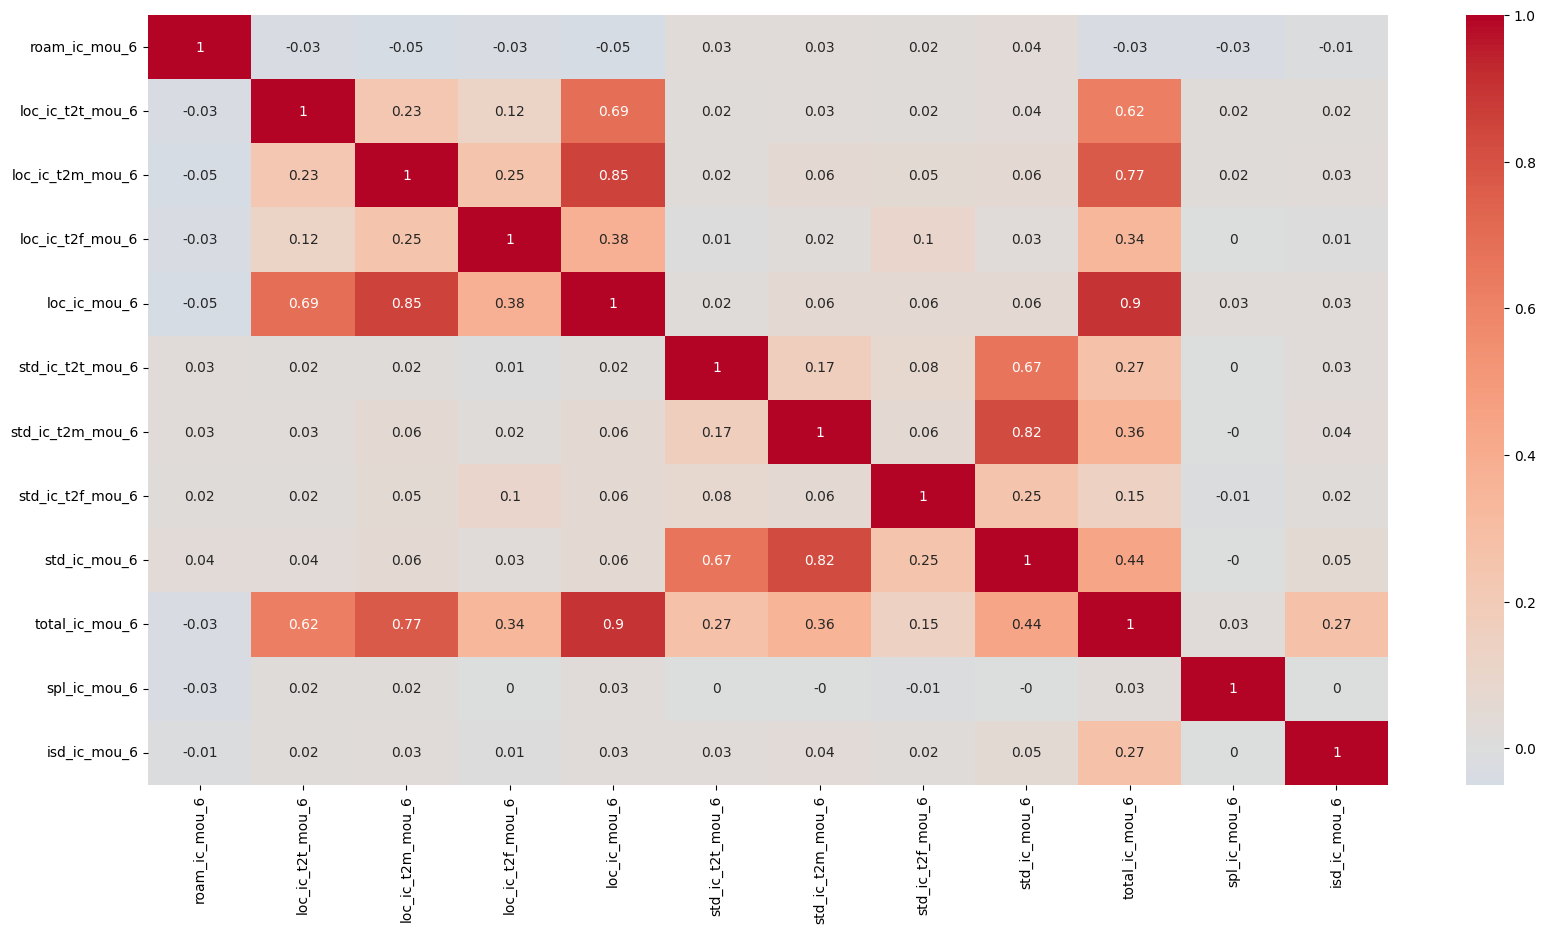

In [3438]:
plot_heatmap(telecom_df_high_val_cust, mou_ic_cols6)

Observations : We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.


In [3439]:
# drop columns with total_ic_mou|std_ic_mou|loc_ic_mou
list_total_ic_cols = filter_columns_by_regex(telecom_df_high_val_cust, 'total_ic_mou|std_ic_mou|loc_ic_mou')

drop_cols(telecom_df_high_val_cust, list_total_ic_cols)

['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1817087159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


In [3440]:
telecom_df_high_val_cust.shape

(20984, 134)

### Offnet Usage related Features

In [3441]:
offnet_usage_service_col = filter_columns_by_regex(telecom_df_high_val_cust, 'offnet.*mou')

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']


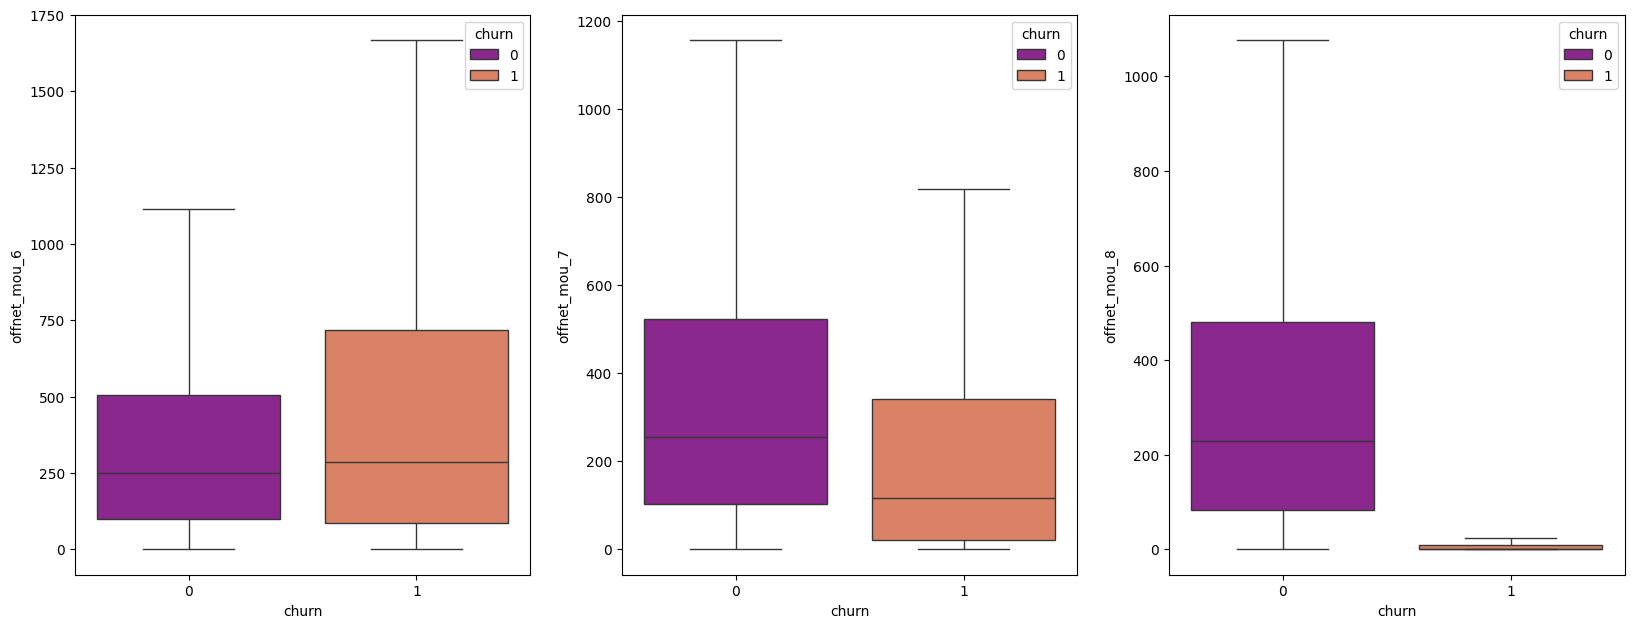

In [3442]:
# Offnet mou values for churned and non churned customers
plot_box_chart(telecom_df_high_val_cust, 'offnet_mou', 'churn')

In [3443]:
# plot_mean_bar_chart(telecom_df_high_val_cust, offnet_usage_service_col)

Observations : We can see the drop for offnet mou services in the 8th month


### ONNET : All kind of calls within the same operator network

In [3444]:
#minutes of usage related columns
onnet_usage_service = filter_columns_by_regex(telecom_df_high_val_cust, '^onnet.*mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']


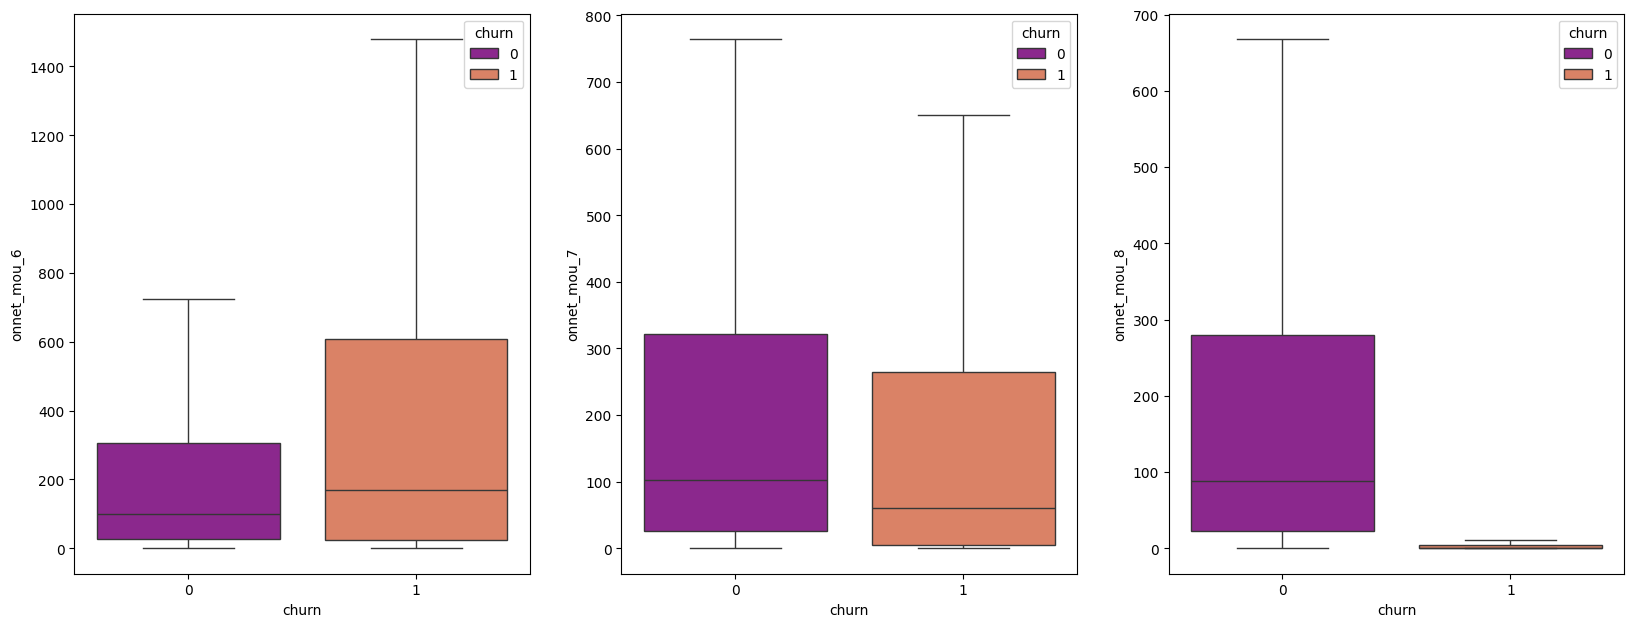

In [3445]:
# Plotting offnet
plot_box_chart(telecom_df_high_val_cust, 'onnet_mou', 'churn')

In [3446]:
# plot_mean_bar_chart(telecom_df_high_val_cust, onnet_usage_service)

Observations : We also see that there is a drop in Onnet usage in the 8th month for churned customers


### Tenure Analysis for Customers

In [3447]:
tenure_data = telecom_df_high_val_cust.copy()

In [3448]:
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()

12    10.733333
15    20.066667
23    15.166667
24    40.633333
27    19.100000
Name: tenure, dtype: float64

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1760500538.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[col], hist=True, kde=False,


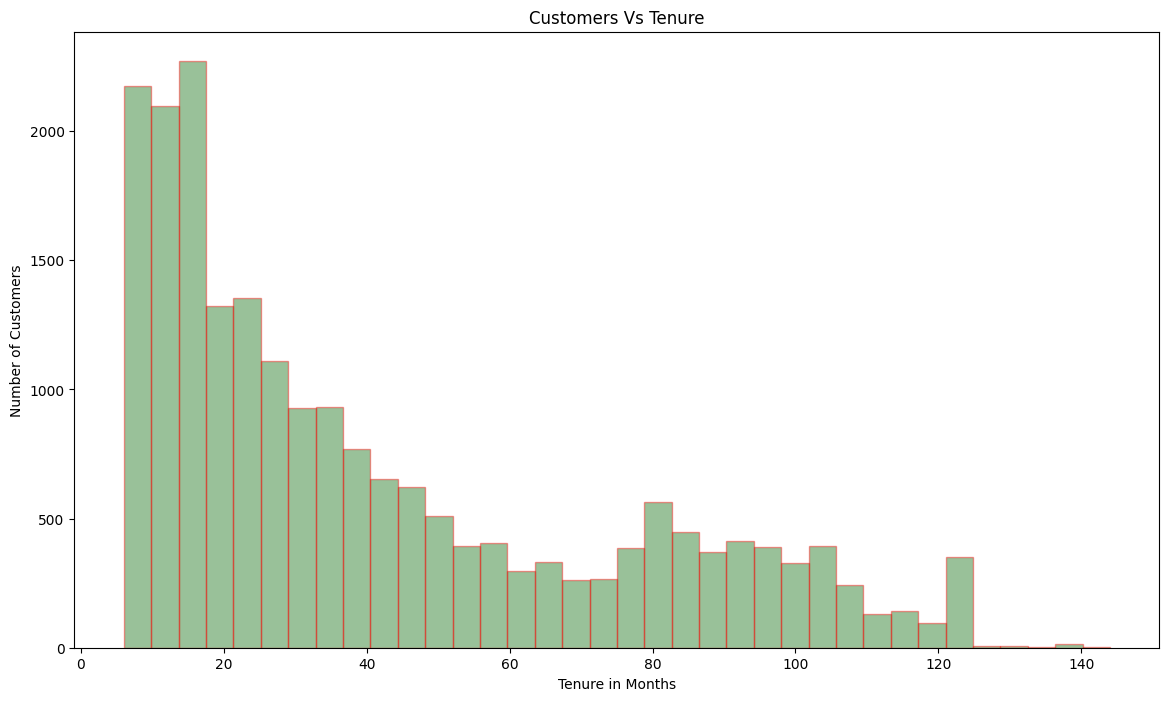

In [3449]:
plot_distplot(tenure_data, 'tenure', 'Tenure in Months', 'Number of Customers', 'Customers Vs Tenure')

In [3450]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

12    6-12 Months
15        1-2 Yrs
23        1-2 Yrs
24        2-5 Yrs
27        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

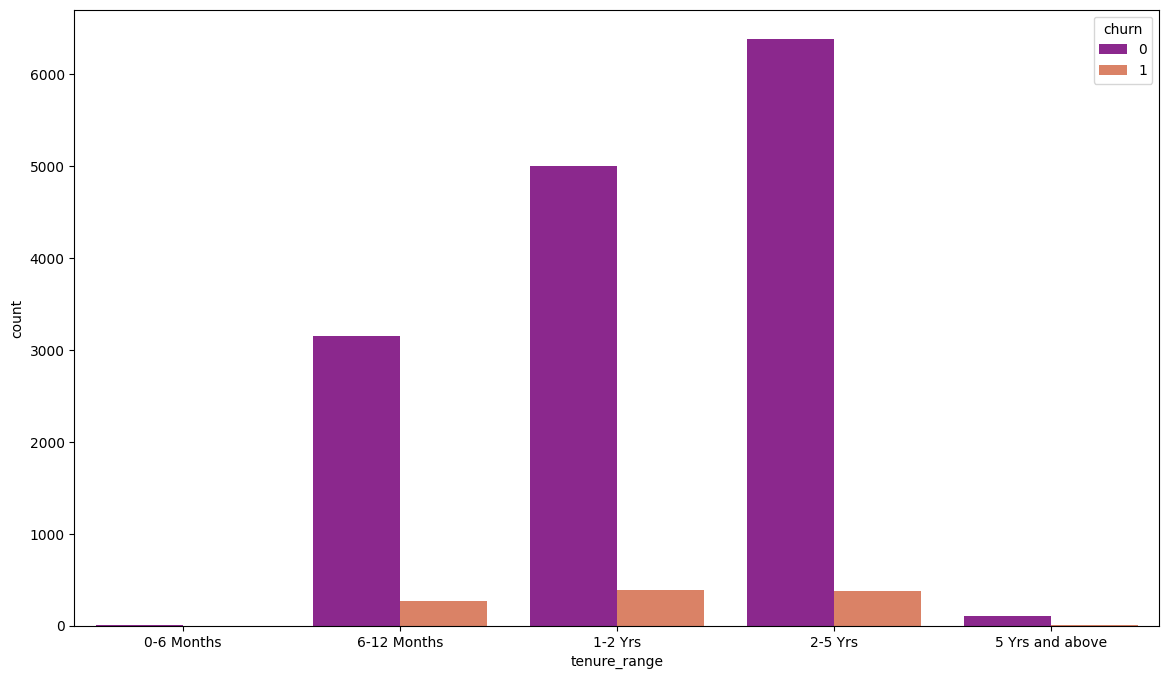

In [3451]:
plot_countplot(tenure_data, 'tenure_range', 'churn')

In [3452]:
# Checking columns with % NA values.
show_na_percentage(telecom_df_high_val_cust)

night_pck_user_8            51.725124
date_of_last_rech_data_8    51.725124
fb_user_8                   51.725124
fb_user_6                   50.443195
night_pck_user_6            50.443195
                              ...    
isd_og_mou_7                 0.000000
isd_og_mou_6                 0.000000
std_og_t2f_mou_8             0.000000
std_og_t2f_mou_7             0.000000
churn                        0.000000
Length: 134, dtype: float64


In [3453]:
# Checking columns with more than 30% NA values.
rmcols = get_percentage_na_columns_by_threshold(telecom_df_high_val_cust, 30.00)

print("\n The Below Columns are removed from the Dataset :\n")
print(rmcols)


 The Below Columns are removed from the Dataset :

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [3454]:
telecom_df_high_val_cust.shape

(20984, 134)

In [3455]:
# Removing these columns
drop_cols(telecom_df_high_val_cust, rmcols)
telecom_df_high_val_cust.shape# verifying the shape of the dataset

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1817087159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols,axis=1,inplace=True)


(20984, 125)

In [3456]:
telecom_df_high_val_cust.drop(['max_rech_data_8'], axis=1,inplace=True) 

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/984991589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df_high_val_cust.drop(['max_rech_data_8'], axis=1,inplace=True)


In [3457]:
telecom_df_high_val_cust.shape

(20984, 124)

In [3458]:
numberic_col = [ 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

In [3459]:
impute_null_columns(telecom_df_high_val_cust, numberic_col)

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/3652335906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace(np.NaN,0.0)


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,...,322,0.00,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,...,602,0.00,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,...,455,0.00,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,222.03,...,1219,0.00,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,390.489,350.985,421.300,8.58,11.48,12.68,133.16,158.73,182.83,...,573,700.40,185.71,173.72,0,209.0,306.0,217.0,826.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69982,69982,146.927,458.054,139.068,15.19,33.91,10.06,105.44,166.83,111.54,...,1577,0.00,0.00,0.00,0,0.0,276.0,0.0,449.0,0
69984,69984,1106.130,1609.381,1686.392,84.91,133.44,178.08,823.86,645.89,703.19,...,283,6.48,102.80,127.41,0,452.0,0.0,0.0,1624.0,0
69989,69989,196.695,298.645,192.440,1.05,0.00,5.83,44.74,32.16,30.93,...,251,107.77,112.70,242.18,0,101.0,234.0,92.0,483.5,0
69996,69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,...,879,0.00,0.00,0.00,0,0.0,0.0,0.0,438.0,0


In [3460]:
# Checking columns with % NA values.
show_na_percentage(telecom_df_high_val_cust)

ic_others_8            3.678994
og_others_8            3.678994
date_of_last_rech_8    1.906214
date_of_last_rech_7    0.328822
date_of_last_rech_6    0.214449
                         ...   
std_og_t2f_mou_8       0.000000
std_og_t2f_mou_7       0.000000
std_og_t2f_mou_6       0.000000
std_og_t2m_mou_8       0.000000
churn                  0.000000
Length: 124, dtype: float64


### Derive new features.

In [3461]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head()

(20984, 124)


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn_probability,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,...,322,0.0,0.00,0.00,0,0.0,0.0,0.0,469.5,0
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,...,602,0.0,0.00,0.00,0,155.0,0.0,155.0,604.5,0
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,...,455,0.0,0.00,0.00,0,0.0,0.0,0.0,1205.0,0
24,24,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,222.03,...,1219,0.0,0.00,0.00,0,24.0,48.0,24.0,469.5,0
27,27,390.489,350.985,421.300,8.58,11.48,12.68,133.16,158.73,182.83,...,573,700.4,185.71,173.72,0,209.0,306.0,217.0,826.0,0


In [3462]:
drop_cols(telecom_df_final, ['total_avg_rech_amnt_6_7_GPhase'])

In [3463]:
telecom_df_final.drop(telecom_df_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_df_final.shape)

(20984, 120)


In [3464]:
col_list = telecom_df_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6]  + telecom_df_final[col_7])/ 2

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [3465]:
col_list_to_drop = telecom_df_final.filter(regex='_6|_7')
telecom_df_final.drop(col_list_to_drop,axis=1,inplace=True)
print (telecom_df_final.shape)

(20984, 81)


In [3466]:
telecom_df_final.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [3467]:
telecom_df_final.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

Observations : We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 124 to 84.


### Training the model

In [3468]:
def split_date(df):
    Y = df["churn"]
    X = df.drop(["churn"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    print("Scaling the data ....")
    return X_scale_final

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca

In [3469]:
telecom_pca_df = telecom_df_final.copy()
telecom_pca_df.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [3470]:
telecom_pca_df.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

In [3471]:
#Splitting in x and y
X,Y=split_date(telecom_pca_df)

In [3472]:
X.head()

,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
12,12,392.024,42.98,644.43,0.0,0.0,3.98,51.24,0.00,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
15,15,338.286,194.43,197.09,0.0,0.0,194.43,185.88,4.94,0.00,...,77.0,77.0,130.21,0.00,0.5,0.0,0.0,0.0,0.000,77.5
23,23,479.762,0.89,386.91,0.0,0.0,0.89,378.01,8.88,0.00,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,0.0
24,24,240.449,29.86,222.03,0.0,0.0,29.86,99.86,0.00,0.36,...,23.0,34.5,0.02,0.00,0.0,1.5,0.0,0.0,0.000,36.0
27,27,421.300,12.68,182.83,0.0,0.0,12.68,157.23,25.59,0.00,...,153.0,254.5,49.46,325.04,0.5,2.0,0.0,0.5,179.715,257.5


In [3473]:
Y.head(10)

12    0
15    0
23    0
24    0
27    0
33    0
39    0
45    0
49    0
52    0
Name: churn, dtype: int64

In [3474]:
print("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

Percenatge of Churned Customer data : 5.47


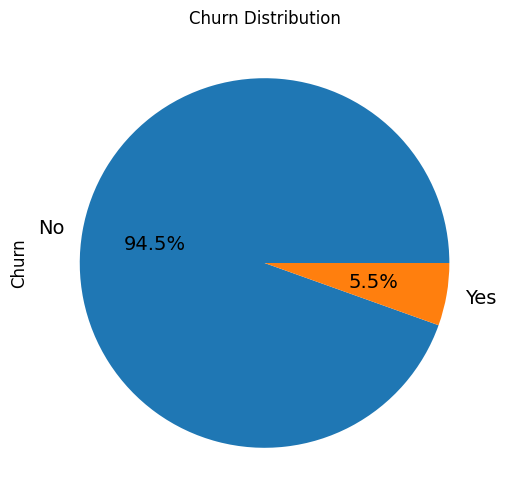

In [3475]:
plot_pie_chart(telecom_pca_df, 'churn', 'Churn', 'Churn Distribution')

### Scaling the data to normalize all the fields

In [3476]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

Scaling the data ....
(20984, 80)


,id,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-1.741335,-0.254323,-0.437773,0.614531,-0.167619,-0.190201,-0.328977,-0.463071,-0.319299,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
1,-1.741186,-0.358685,-0.114965,-0.326099,-0.167619,-0.190201,0.476813,0.126022,-0.065164,-0.235883,...,-0.000637,-0.263219,0.068408,-0.401420,0.820536,-0.368311,-0.393106,-0.207546,-0.413242,-0.266345
2,-1.740788,-0.083930,-0.527486,0.073039,-0.167619,-0.190201,-0.342050,0.966652,0.137527,-0.235883,...,-0.734751,-0.679548,-0.376848,-0.401420,-0.463536,-0.368311,-0.393106,-0.207546,-0.413242,-0.682782
3,-1.740739,-0.548691,-0.465738,-0.273658,-0.167619,-0.190201,-0.219479,-0.250343,-0.319299,-0.184745,...,-0.515470,-0.493011,-0.376780,-0.401420,-0.463536,0.329829,-0.393106,-0.207546,-0.413242,-0.489341
4,-1.740590,-0.197467,-0.502356,-0.356084,-0.167619,-0.190201,-0.292167,0.000669,0.997164,-0.235883,...,0.723943,0.696500,-0.207719,-0.024537,0.820536,0.562542,-0.393106,0.332660,0.043126,0.700864


In [3477]:
#replacing nan with 0
X_scaled=impute_null_columns(X_scaled, None)

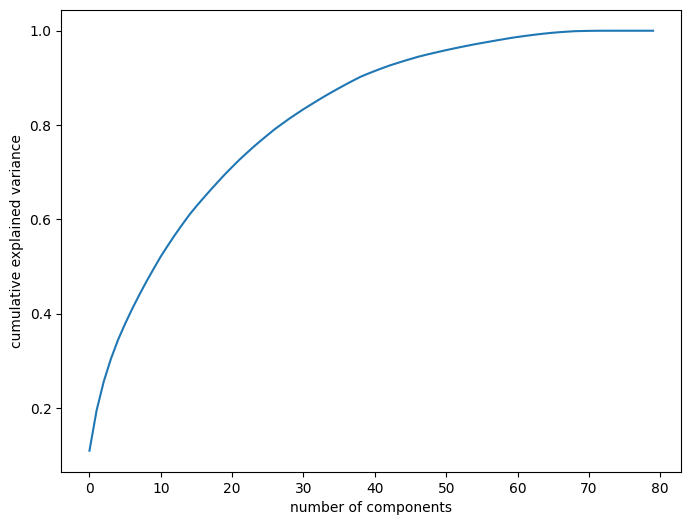

,PC1,PC2,PC3,Feature
0,0.003295,0.003640,-0.005005,id
1,0.049261,0.319631,0.113330,arpu_8
2,-0.082087,0.138639,0.149792,onnet_mou_8
3,-0.067617,0.229695,0.075803,offnet_mou_8
4,0.000553,0.043895,0.004392,roam_ic_mou_8


In [3478]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head()

In [3479]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.93,  19.47,  25.59,  30.38,  34.42,  37.86,  41.04,  44.02,
        46.85,  49.52,  52.13,  54.47,  56.74,  58.88,  60.96,  62.81,
        64.55,  66.27,  67.93,  69.57,  71.1 ,  72.61,  74.  ,  75.37,
        76.67,  77.92,  79.15,  80.25,  81.34,  82.36,  83.35,  84.29,
        85.22,  86.13,  87.  ,  87.85,  88.67,  89.47,  90.24,  90.88,
        91.48,  92.05,  92.6 ,  93.09,  93.57,  94.02,  94.46,  94.85,
        95.21,  95.56,  95.91,  96.23,  96.54,  96.84,  97.14,  97.41,
        97.68,  97.95,  98.21,  98.47,  98.7 ,  98.9 ,  99.1 ,  99.28,
        99.45,  99.6 ,  99.72,  99.82,  99.92,  99.96, 100.  , 100.02,
       100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03, 100.03])

Observation : Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our modeling


### Model Prediction and Evaluation

In [3480]:
test_data=pd.read_csv("test.csv")

In [3481]:
test_data.shape

(30000, 171)

In [3482]:
'churn_probability' in test_data.columns.to_list()

False

In [3483]:
telecom_pca_df.shape

(20984, 81)

In [3484]:
telecom_pca_df.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_lo

In [3485]:
x_train=X
y_train=Y

In [3486]:
X.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_

In [3487]:
recharge_columns = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
test_data = impute_null_columns(test_data,recharge_columns)

In [3488]:
# adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
test_data = add_total_rech_amt_data(test_data)

In [3489]:
test_data = add_avg_rech_amt_good_phase(test_data, rc_cols)

In [3490]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 175 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(139), int64(27), object(9)
memory usage: 40.1+ MB


In [3491]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = test_data.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)
test_data_high_val_cust = test_data

In [3492]:
drop_col_with_unique_col_map = get_drop_col_with_unique_col(test_data_high_val_cust)

{'circle_id': 1, 'loc_og_t2o_mou': 2, 'std_og_t2o_mou': 2, 'loc_ic_t2o_mou': 2, 'last_date_of_month_6': 1, 'last_date_of_month_7': 2, 'last_date_of_month_8': 2, 'std_og_t2c_mou_6': 2, 'std_og_t2c_mou_7': 2, 'std_og_t2c_mou_8': 2, 'std_ic_t2o_mou_6': 2, 'std_ic_t2o_mou_7': 2, 'std_ic_t2o_mou_8': 2}


In [3493]:
print("Features before dropping unique values : "+ str(test_data_high_val_cust.shape[1]))
test_data_high_val_cust.drop(drop_col_with_unique_col_map.keys(),axis=1,inplace=True)
print("Features after dropping unique values : "+ str(test_data_high_val_cust.shape[1]))

Features before dropping unique values : 175
Features after dropping unique values : 162


In [3494]:
test_data_high_val_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 162 entries, id to total_avg_rech_amnt_6_7_GPhase
dtypes: float64(130), int64(26), object(6)
memory usage: 37.1+ MB


In [3495]:
test_data_high_val_cust = convert_to_datetime(test_data_high_val_cust, date_cols)
test_data_high_val_cust.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,0.0,0.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,NaN,NaN,462,0.00,0.00,0.00,0.0,0.0,0.0,423.0


In [3496]:
#Getting the last day recharge amount columns
last_day_rech_amt = filter_columns_by_regex(test_data_high_val_cust, 'day')

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']


In [3497]:
usage_2g_and_3g = filter_columns_by_regex(test_data_high_val_cust, '2g|3g')

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [3498]:
# check Volume based cost 
vbc_column = filter_columns_by_regex(test_data_high_val_cust, 'vbc_')

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']


In [3499]:
# Renaming month named vbc columns to 6,7,8,9 format
test_data_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'}, inplace=True)

vbc_column = filter_columns_by_regex(test_data_high_val_cust, 'vbc_3g')

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']


In [3500]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = filter_columns_by_regex(test_data_high_val_cust, 'sachet_2g|sachet_3g')

['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [3501]:
# Checking columns for average revenue per user
arpu_cols = filter_columns_by_regex(test_data_high_val_cust, 'arpu_')

['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']


In [3502]:
mou_cols = filter_columns_by_regex(test_data_high_val_cust, 'mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6'

In [3503]:
impute_null_columns(test_data, mou_cols.to_list())

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,69999,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,...,NaN,NaN,1692,0.00,0.00,0.00,0.0,0.0,0.0,96.5
1,70000,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,...,NaN,NaN,2533,0.00,0.00,0.00,0.0,0.0,0.0,500.0
2,70001,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,...,NaN,NaN,277,525.61,758.41,241.84,0.0,0.0,0.0,750.0
3,70002,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,...,NaN,NaN,1244,0.00,0.00,0.00,0.0,0.0,0.0,185.0
4,70003,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,...,NaN,NaN,462,0.00,0.00,0.00,0.0,0.0,0.0,423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99994,718.870,396.259,406.150,324.46,250.01,285.41,190.36,166.14,221.96,...,NaN,NaN,1255,3.71,105.64,61.48,126.0,0.0,0.0,677.0
29996,99995,218.327,324.070,374.981,263.79,467.24,650.26,108.53,124.11,189.76,...,0.0,NaN,2258,0.00,0.00,0.00,0.0,178.0,0.0,396.5
29997,99996,139.473,38.230,180.194,11.08,14.89,19.94,37.24,16.74,45.28,...,NaN,NaN,440,0.00,0.00,0.00,0.0,0.0,0.0,75.0
29998,99997,1122.912,781.121,257.439,122.74,50.23,26.46,1854.09,1088.83,306.16,...,NaN,NaN,810,0.00,0.00,0.00,0.0,0.0,0.0,1081.0


In [3504]:
mou_og_cols6 = filter_columns_by_regex(test_data_high_val_cust, '.*_og_.*mou_6')

['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'total_og_mou_6']


In [3505]:
list_total_og_cols = filter_columns_by_regex(test_data_high_val_cust, 'total_og_mou|std_og_mou|loc_og_mou')

['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']


In [3506]:
test_data_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)

In [3507]:
mou_ic_cols6 = filter_columns_by_regex(test_data_high_val_cust, '.*_ic_.*mou_6')

['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6']


In [3508]:
list_total_ic_cols = filter_columns_by_regex(test_data_high_val_cust, 'total_ic_mou|std_ic_mou|loc_ic_mou')

['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']


In [3509]:
test_data_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)

In [3510]:
offnet_usage_service_col = filter_columns_by_regex(test_data_high_val_cust, 'offnet.*mou')

['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']


In [3511]:
onnet_usage_service = filter_columns_by_regex(test_data_high_val_cust, '^onnet.*mou')

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']


In [3512]:
test_data_high_val_cust.shape

(30000, 144)

In [3513]:
tenure_data = test_data_high_val_cust.copy()
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()

0    56.400000
1    84.433333
2     9.233333
3    41.466667
4    15.400000
Name: tenure, dtype: float64

/var/folders/20/4khh4cyn4g7b5_1xnqv8916h0000gn/T/ipykernel_59438/1760500538.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[col], hist=True, kde=False,


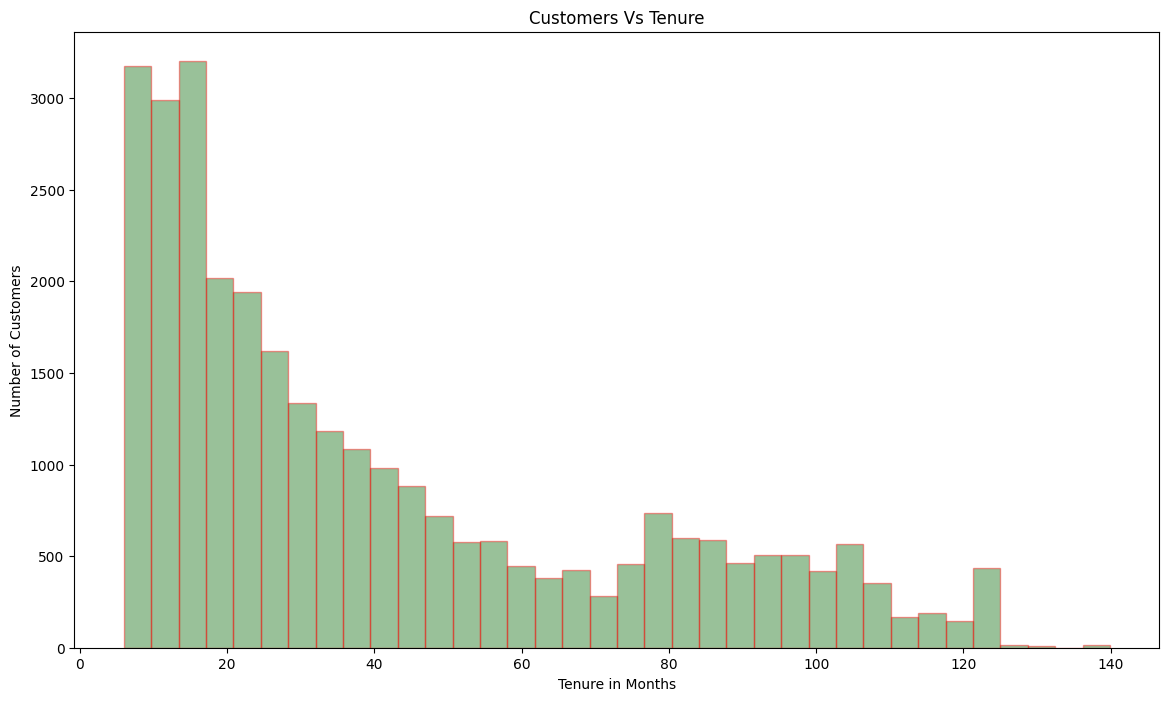

In [3514]:
plot_distplot(tenure_data, 'tenure', 'Tenure in Months', 'Number of Customers', 'Customers Vs Tenure')

In [3515]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0        2-5 Yrs
1            NaN
2    6-12 Months
3        2-5 Yrs
4        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

In [3516]:
test_data_final = test_data_high_val_cust.copy()
print(test_data_final.shape)
test_data_final.head(3)
test_data_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
test_data_final.drop(test_data_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (test_data_final.shape)

(30000, 144)
(30000, 137)


In [3517]:
col_list = test_data_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    test_data_final[avg_col_name] = (test_data_final[col_6]  + test_data_final[col_7])/ 2

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
count_rech_2g
count_rech_3g
av_rech_amt_data
vol_2g_mb
vol_3g_mb
arpu_3g
arpu_2g
night_pck_user
monthly_2g
sachet_2g
monthly_3g
sachet_3g
fb_user
vbc_3g
total_rech_amt_data


In [3518]:
test_data_final.columns.to_list()

['id',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mo

In [3519]:
test_x=test_data_final[['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon',
       'vbc_3g_8', 'total_rech_amt_data_8',
       'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67',
       'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_mou_av67', 'avg_loc_og_t2c_mou_av67',
       'avg_std_og_t2t_mou_av67', 'avg_std_og_t2m_mou_av67',
       'avg_std_og_t2f_mou_av67', 'avg_isd_og_mou_av67', 'avg_spl_og_mou_av67',
       'avg_og_others_av67', 'avg_loc_ic_t2t_mou_av67',
       'avg_loc_ic_t2m_mou_av67', 'avg_loc_ic_t2f_mou_av67',
       'avg_std_ic_t2t_mou_av67', 'avg_std_ic_t2m_mou_av67',
       'avg_std_ic_t2f_mou_av67', 'avg_spl_ic_mou_av67', 'avg_isd_ic_mou_av67',
       'avg_ic_others_av67', 'avg_total_rech_num_av67',
       'avg_total_rech_amt_av67', 'avg_max_rech_amt_av67',
       'avg_last_day_rch_amt_av67', 'avg_total_rech_data_av67',
       'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67',
       'avg_vol_2g_mb_av67', 'avg_vol_3g_mb_av67', 'avg_monthly_2g_av67',
       'avg_sachet_2g_av67', 'avg_monthly_3g_av67', 'avg_sachet_3g_av67',
       'avg_vbc_3g_av67', 'avg_total_rech_amt_data_av67']]

In [3520]:
test_x.shape

(30000, 79)

In [3521]:
X.columns

Index(['id', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'churn_probability',
       'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
       'avg_loc_og_t2f_

In [3522]:
X=X.replace(np.nan,0)

In [3523]:
x_train=X
y_train=Y
x_test=test_x

In [3524]:
x_train.shape

(20984, 80)

In [3525]:
x_test.shape

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(30000, 79)

In [3526]:
X_train=x_train.drop(['churn_probability'],axis=1)

In [3527]:
y_train.head()

12    0
15    0
23    0
24    0
27    0
Name: churn, dtype: int64

In [3528]:
y_train.shape

(20984,)

### Tree Model Regression

In [3529]:
telecom_tree_df = telecom_df_final.copy()

In [3530]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [3531]:
x_test=x_test.replace(np.nan,0)

In [3532]:
x_test.shape

(30000, 79)

In [3533]:
# Making predictions
predictions = rfc.predict(x_test)
predictions

array([0, 0, 1, ..., 0, 0, 0])

Observation : So far so good, let's now look at the list of hyperparameters which we can tune to improve model performance.


In [3534]:

def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Tuning max_depth

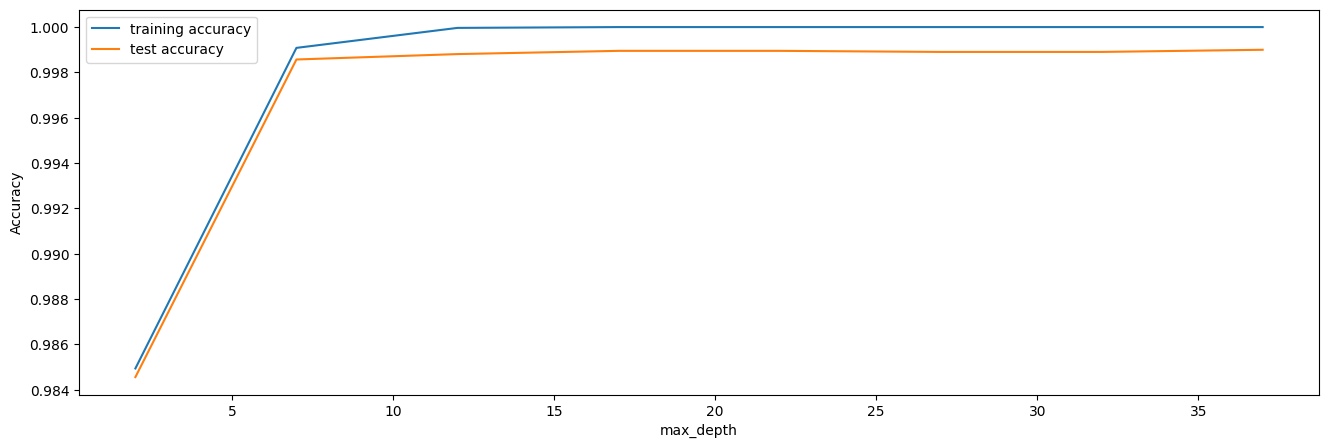

In [3535]:
# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

### Tuning n_estimators

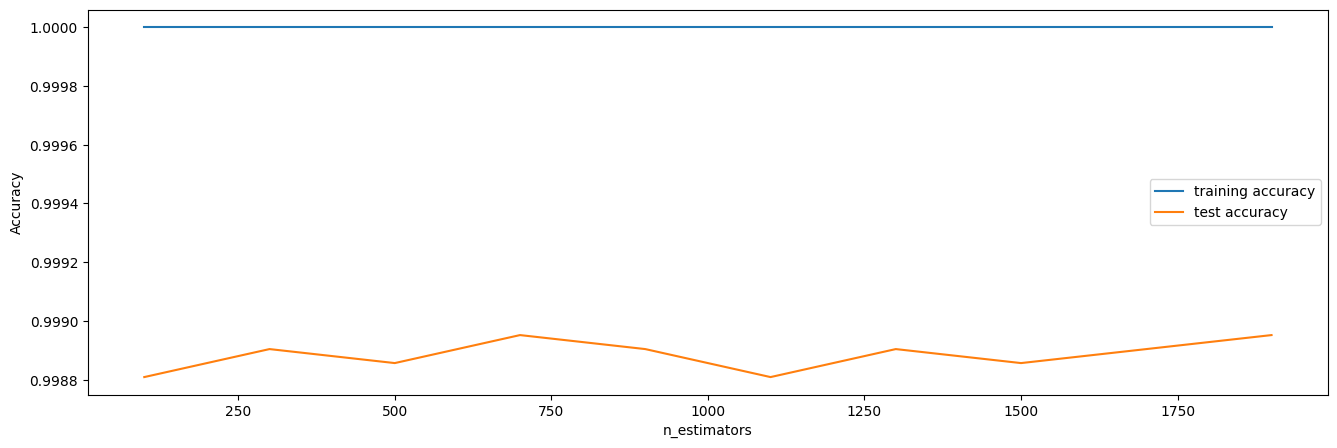

In [3536]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 2000, 200)}
tune_hyperparameter(parameters,x_train,y_train)

### Tuning max_features

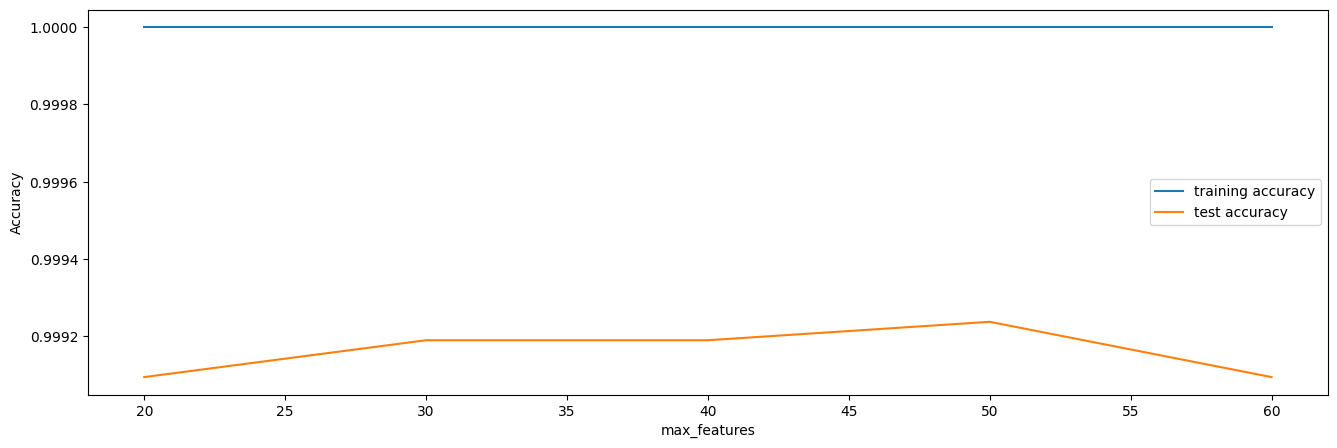

In [3537]:
# parameters to build the model on
parameters = {'max_features': [20,30,40,50,60]}
tune_hyperparameter(parameters,x_train,y_train,4)

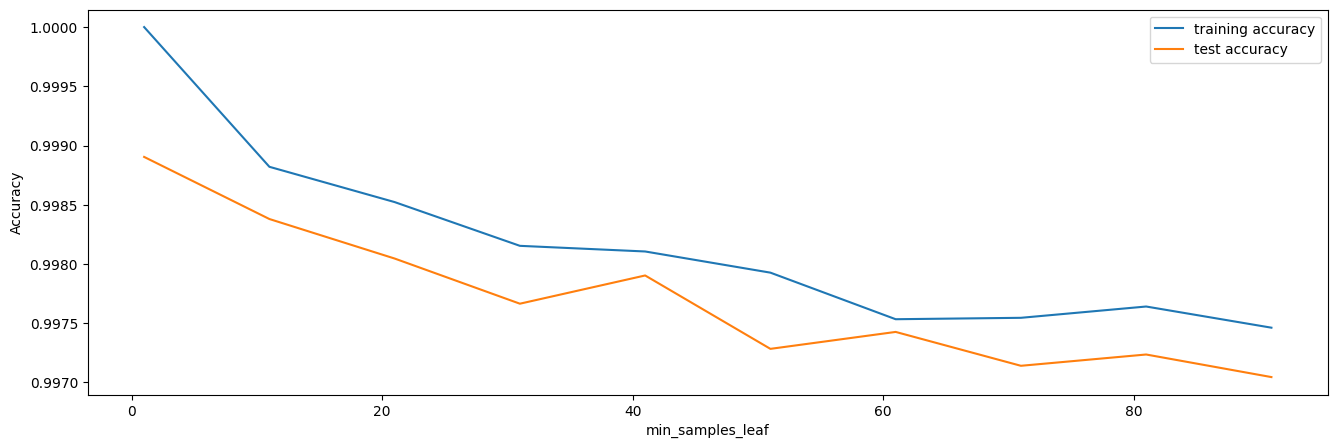

In [3538]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

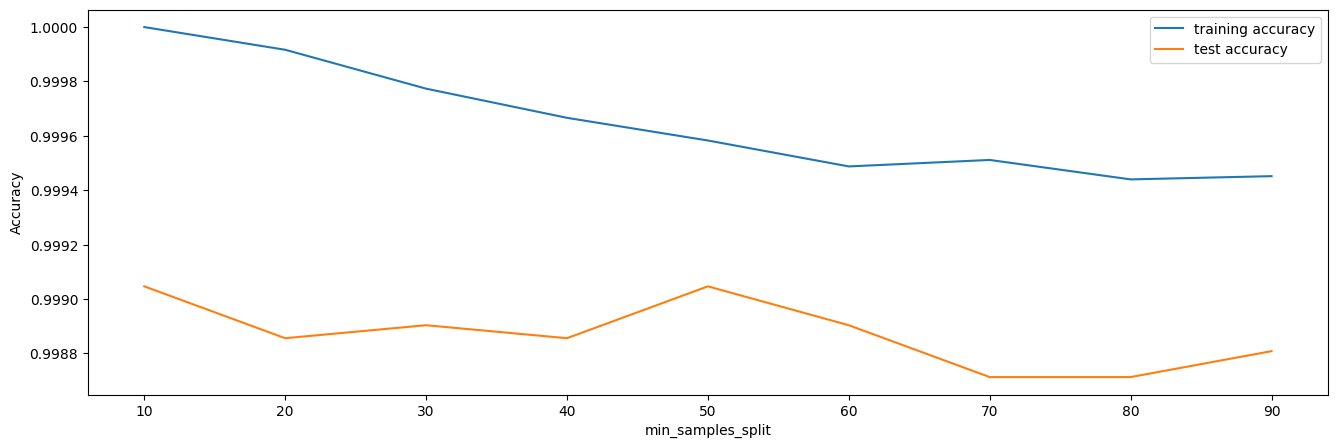

In [3539]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

### Grid Search to Find Optimal Hyperparameters

In [3540]:
#We can now find the optimal hyperparameters using GridSearchCV.
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [7,12],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10,20],
    'min_samples_split': [10,20,30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [3541]:
# Fit the grid search to the data
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 12], 'max_features': [40],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [200]},
             return_train_score=True, verbose=1)

In [3542]:
#printing the optimal accuracy score and hyperparameters
print('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

We can get accuracy of 1.0 using {'max_depth': 12, 'max_features': 40, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [3543]:
print("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

Max accuracy with Random Forest classifier - 1.0


### Building and Evaluating the Final Model for Random Forest

In [3544]:
rfc = RandomForestClassifier(max_depth=12,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=10,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, max_features=40, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=200, n_jobs=-1)

In [3545]:
# Making predictions
predictions = rfc.predict(x_test)

In [3546]:
solution_data=pd.DataFrame(predictions,index=test_data['id'],columns=['churn_probability'])

In [3547]:
solution_data

,churn_probability
id,
69999,0
70000,0
70001,1
70002,0
70003,0
...,...
99994,0
99995,0
99996,0


In [3548]:
solution_data.to_csv("Submission.csv")